# Overview:
This collection of notebooks perform four different experiments:
1. Source verification: The algorithm verifies if an image comes from a purported source, or not.
1. Verification stability over time: does performance persist over time?
1. Verification performance between closed-set and open-set conditions.
1. Source identification (N-class classification)

# Experiment 01
This notebook generates results for Experiment 01: Source Verification.  

To summarize: a model is presented with an image, and a news source from which the image is purported to originate. We train and evaluate a binary classifier to decide if the image is from the purported source or not.  We perform experiments to evaluate the performance for each purported source.

Note on dataset pruning:  
We collected a large dataset of images with automated scrapers. This resulted in significant imbalance for some sources.  Hence, we kept at most the first 4,000 images from each source, and dropped other images, to form a smaller dataset with limited imbalance for these experiments.  The pruned dataset used in all experiments is the dataset that we release.

## Data Exploration
In the next group of cells, load and explore the dataset.

In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import subprocess
import random
import pickle
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# from tqdm.autonotebook import tqdm
from tqdm.notebook import tqdm

import uncertainties

from image_compression_attribution.common.code.models import quant_matrices, compr_levels
from image_compression_attribution.common.code.summarize_quant_matrices import summarize_compression_features

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', 500)

from sklearn.metrics import make_scorer, roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#Note: this calculation method does not seem to work well when there are large gaps
#in the ROC curve. Hence, only use this if you have interpolated between
#ROC curve data points to fill in the roc curve on a grid with small intervals.
#https://github.com/scikit-learn/scikit-learn/issues/15247#issuecomment-542138349
def calculate_eer(fpr, tpr):
    '''
    Returns the equal error rate for a binary classifier output.
    '''
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    return eer
  
#---------------------------------------------------------------
#Code to combine mean value and uncertainty estimate into
#one formatted string, like 3.14 +/- .02 becomes "3.14(2)"

import string

class ShorthandFormatter(string.Formatter):
  """https://pythonhosted.org/uncertainties/user_guide.html"""

  def format_field(self, value, format_spec):
    if isinstance(value, uncertainties.UFloat):
      return value.format(format_spec+'S')  # Shorthand option added
    # Special formatting for other types can be added here (floats, etc.)
    else:
      # Usual formatting:
      return super(ShorthandFormatter, self).format_field(
        value, format_spec)

def uncertainty_format_arrays(mean_vals, uncertainty_vals):
  frmtr_uncertainty = ShorthandFormatter()
  
  vals_formatted = []
  for mean, uncert in zip(mean_vals, uncertainty_vals):
    number = uncertainties.ufloat(mean, uncert)
    str_formatted = frmtr_uncertainty.format("{0:.1u}", number)
    vals_formatted.append(str_formatted)
  return vals_formatted


/app/image_compression_attribution/common/code/summarize_quant_matrices.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  #works in notebooks or scripts


In [3]:
#Fix rnd seed so results reproducible
RND_SEED=1234
np.random.seed(RND_SEED)

In [4]:
SUMMARY_FILE = "/app/dataset/data.csv"

RESULTS_FOLDER = "results/exp_01"
os.makedirs(RESULTS_FOLDER, exist_ok=True)

df = pd.read_csv(SUMMARY_FILE)

#Drop non-image files, e.g. html files returned
#due to download errors

df, df_dropped = df[ df['mime'].str.startswith('image') ].reset_index(drop=True), \
  df[ ~df['mime'].str.startswith('image') ].reset_index(drop=True)

sources = sorted(list(df['source'].unique()))


In [5]:
df

articleUrl                                                       articleHash                                                                                                                                                           imageUrl      source        mime  compression                            q_hash          q_name            timestamp
0                     https://www.abc.net.au/news/2020-05-25/toowoomba-unemployment-hits-horrific-level/12282346                                  4de7b04b17622bc838468486216f9878      https://live-production.wcms.abc-cdn.net.au/10d55dfa1fef3ec5f4f20cdac0b64df5?impolicy=wcms_crop_resize&cropH=528&cropW=938&xPos=1&yPos=0&width=862&height=485  abc.net.au  image/webp           92                               NaN        webp_092  2020-05-25 00:00:00
1      https://www.abc.net.au/news/2017-01-11/trade-war-between-us-and-china-a-major-threat-to-australia/8172562                                  99770eadd0f12e1c63df525a8c739f8c    https://live-production.wcms.abc-cdn.net.au/bcbaa4880d63e1b7c46ac95773583381?impolicy=wcms_crop_resize&cropH=1037&cropW=1851&xPos=0&yPos=0&width=862&height=485  abc.net.au  image/webp           92                               NaN        webp_092  2017-01-11 00:00:00
2              https://www.abc.net.au/news/2021-01-31/trainee-guide-dogs-go-for-test-runs-with-handlers/13107128                                  90c0fcf3f9dd12d2770ac4092ca9f612    https://live-production.wcms.abc-cdn.net.au/28314158cc17db94d2062a7539d49fd9?impolicy=wcms_crop_resize&cropH=1515&cropW=2272&xPos=0&yPos=0&width=862&height=575  abc.net.au  image/webp           92                               NaN        webp_092  2021-01-31 00:00:00
3              https://www.abc.net.au/news/2021-01-31/trainee-guide-dogs-go-for-test-runs-with-handlers/13107128                                  90c0fcf3f9dd12d2770ac4092ca9f612  https://live-production.wcms.abc-cdn.net.au/be7013fd935ad10ecd612700c2973c9b?impolicy=wcms_crop_resize&cropH=2250&cropW=2250&xPos=375&yPos=0&width=862&height=862  abc.net.au  image/webp           92                               NaN        webp_092  2021-01-31 00:00:00
4              https://www.abc.net.au/news/2021-01-31/trainee-guide-dogs-go-for-test-runs-with-handlers/13107128                                  90c0fcf3f9dd12d2770ac4092ca9f612    https://live-production.wcms.abc-cdn.net.au/b639a168ddb98a55e2c46628278f6063?impolicy=wcms_crop_resize&cropH=2001&cropW=3000&xPos=0&yPos=0&width=862&height=575  abc.net.au  image/webp           92                               NaN        webp_092  2021-01-31 00:00:00
...                                                                                                          ...                                                               ...                                                                                                                                                                ...         ...         ...          ...                               ...             ...                  ...
64680                    https://www.voanews.com/usa/police-ohio-city-pledge-thorough-probe-black-teens-shooting  59bf6d29b76b4ecb4f52770f5d0f83db350da788309498666ca0a9ebfcb6bcb5                                          https://im-media.voltron.voanews.com/Drupal/01live-166/styles/892x501/s3/2019-04/DC772857-F881-4A9E-B36A-B693023E9514.jpg     voanews  image/jpeg           50  48c9be01d998be93be725587386b3028  jpeg_050_48c9b  2016-09-15 18:20:00
64681                    https://www.voanews.com/usa/police-ohio-city-pledge-thorough-probe-black-teens-shooting  59bf6d29b76b4ecb4f52770f5d0f83db350da788309498666ca0a9ebfcb6bcb5                 https://im-media.voltron.voanews.com/Drupal/01live-166/styles/sourced_737px_wide/s3/2019-04/48F9FC10-1A1C-4D52-949E-93D7CA7AEF2A.png?itok=DnRzA_-G     voanews  image/webp           92                               NaN        webp_092  2016-09-15 18:20:00
64682                    https://www.voanews.com/usa

In [6]:
print(" Size of dataset: {}\n".format(len(df)))

print(" Number of unique compression levels observed: {}\n".format(len(df['compression'].unique())))
print(" Number of unique compression settings: {}".format(len(df['q_name'].unique())))

 Size of dataset: 64685

 Number of unique compression levels observed: 55

 Number of unique compression settings: 255


### Count number of images from each source
Note that some have big numbers, like aljazeera at over 32k, while others have only a few hundred.

In [7]:
df.groupby('source')['imageUrl'].count()

source
abc.net.au              4000
airforcetimes.com        391
aljazeera               4000
allafrica.com            171
americanfreepress       1098
asahi.com                602
bbc                     4000
canadiandimension       2789
ceasefire               3855
centurywire              133
egypttoday              4000
france24                4000
ghanaiantimes.com.gh     122
globaltimes              604
hindustantimes.com      1827
japantimes.co.jp        1282
koreatimes.co.kr        4000
militarytimes.com       1349
navytimes.com            474
nst                      213
oneindia.com            1512
rferl                    251
russiatoday              190
sbs.com.au              2925
straitstimes            4000
taipeitimes             4000
thestar.com             4000
timesofindia            4000
trtworld                4000
voanews                  897
Name: imageUrl, dtype: int64

## Summarize dataset:

In [8]:
print("saving data summaries:")

print(" number of sources: {}\n".format(len(df['source'].unique())))
with open(os.path.join(RESULTS_FOLDER,"num_sources.txt"),"w") as file1:
  file1.write("{}".format(len(df['source'].unique())))

print(" Number of unique articles: {}".format(len(df['articleHash'].unique())))
with open(os.path.join(RESULTS_FOLDER,"num_articles_full_dataset.txt"),"w") as file1:
  file1.write("{}".format(len(df['articleHash'].unique())))

print(" Number of images, excluding dropped samples: {}".format(len(df)))
with open(os.path.join(RESULTS_FOLDER,"num_samples_full_dataset.txt"),"w") as file1:
  file1.write("{}".format(len(df)))

print(" Number of unique compression levels observed: {}".format(len(df['compression'].unique())))
with open(os.path.join(RESULTS_FOLDER,"num_compression_levels.txt"),"w") as file1:
  file1.write("{}".format(len(df['compression'].unique())))

print(" Number of unique values of 'q_name': {}".format(len(df['q_name'].unique())))
with open(os.path.join(RESULTS_FOLDER,"num_q_name_values.txt"),"w") as file1:
  file1.write("{}".format(len(df['q_name'].unique())))

saving data summaries:
 number of sources: 30

 Number of unique articles: 34740
 Number of images, excluding dropped samples: 64685
 Number of unique compression levels observed: 55
 Number of unique values of 'q_name': 255


### common compression settings:
first col is the compression hash, second col is the percentage of samples with that setting

In [9]:
df['q_name'].value_counts()/len(df)*100

webp_092          19.789750
jpeg_080_29ef7    15.498184
jpeg_075_12548    11.506532
jpeg_090_6a1d7     7.726675
jpeg_091_56de8     4.967148
jpeg_065_91d19     3.421195
png_092            3.351627
jpeg_100_b871b     3.054804
jpeg_074_93816     2.955863
jpeg_050_48c9b     2.580196
jpeg_085_df755     2.202984
jpeg_099_e09ce     2.151967
jpeg_079_ca6db     2.108681
jpeg_094_e79bf     1.780938
jpeg_082_b3441     1.703641
jpeg_045_af3fe     1.572235
jpeg_086_8e092     1.244493
jpeg_094_3f467     1.229033
jpeg_070_c19e8     1.167195
jpeg_099_d650a     1.094535
jpeg_099_caee6     0.986318
jpeg_083_c1dba     0.822447
jpeg_087_66c5a     0.819355
gif_092            0.496251
jpeg_069_a20a5     0.496251
jpeg_055_5302e     0.466878
jpeg_086_2872a     0.445235
jpeg_084_34c24     0.391126
jpeg_095_6738a     0.318466
jpeg_088_b48a2     0.304553
jpeg_065_3c1c3     0.204066
jpeg_086_5efe4     0.202520
jpeg_063_d753a     0.196336
jpeg_091_7c1c5     0.163871
jpeg_094_f964b     0.142228
jpeg_092_3e0f1     0

In [10]:
#This shows jpegs with compression level 80 were employed by 13 websites.
#They constituted 15.5% of our dataset.

In [11]:
df[df['q_name']=='jpeg_080_29ef7']['source'].unique()

array(['abc.net.au', 'aljazeera', 'americanfreepress', 'bbc', 'ceasefire',
       'centurywire', 'egypttoday', 'japantimes.co.jp', 'nst',
       'oneindia.com', 'sbs.com.au', 'straitstimes', 'thestar.com'],
      dtype=object)

In [12]:
len(df[df['q_name']=='jpeg_080_29ef7']['source'].unique())

13

In [13]:
#This shows this compression setting only consists of compression level 80.

In [14]:
df[df['q_name']=='jpeg_080_29ef7']['compression'].unique()

array([80])

# Pre-Experiments: Make Histograms of Compression Quality Levels

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
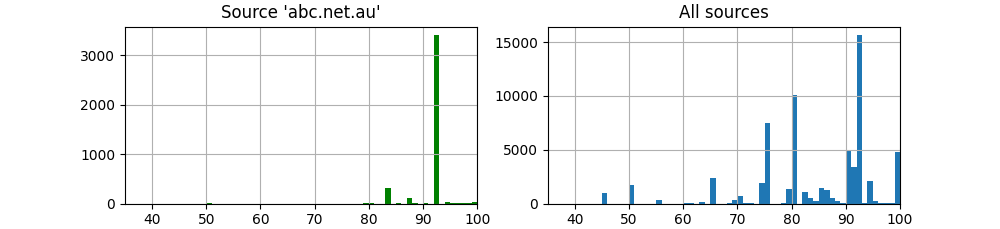

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
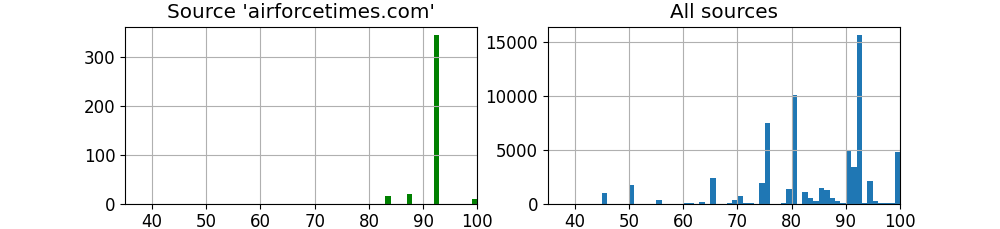

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
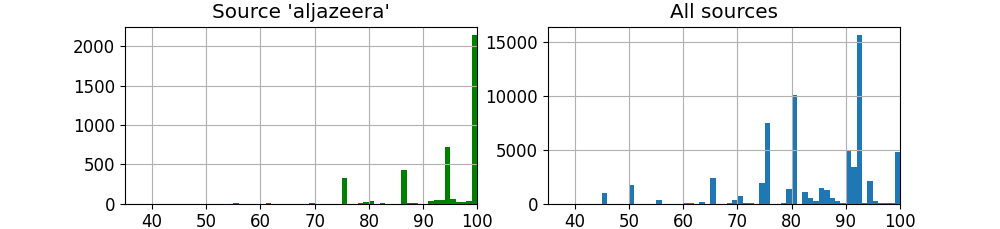

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
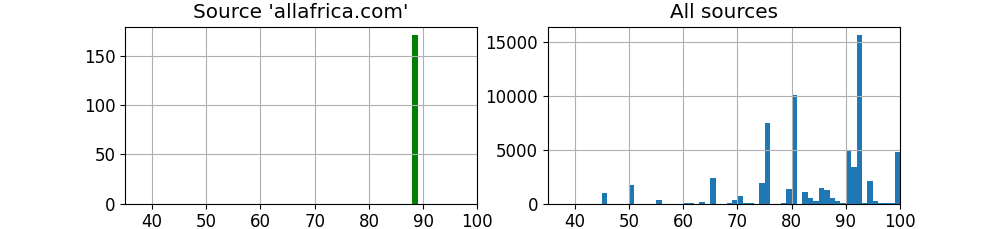

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
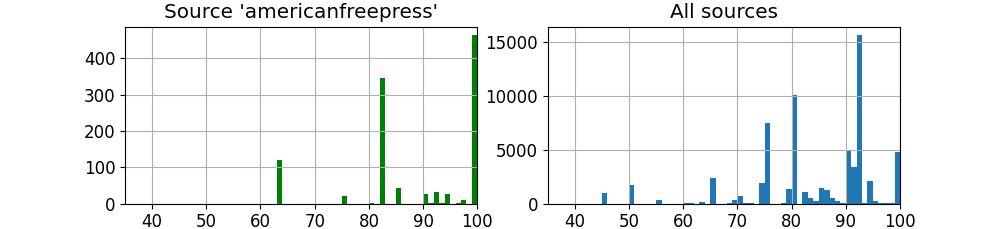

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
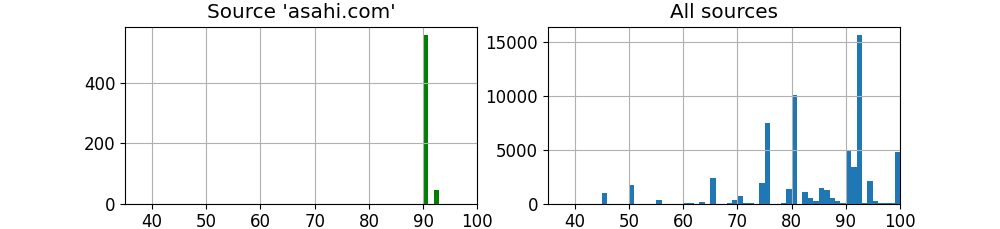

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
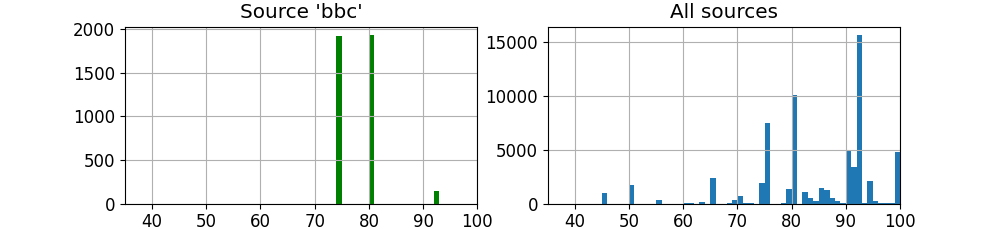

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
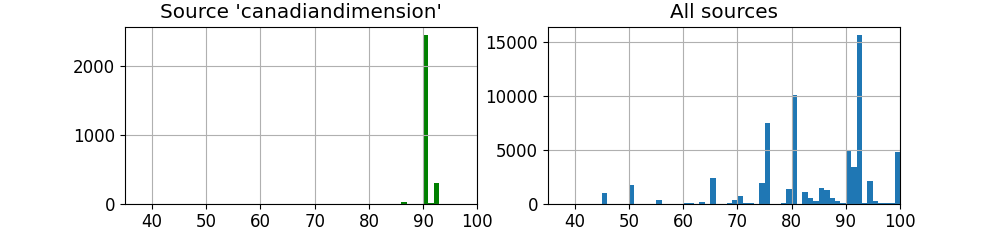

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
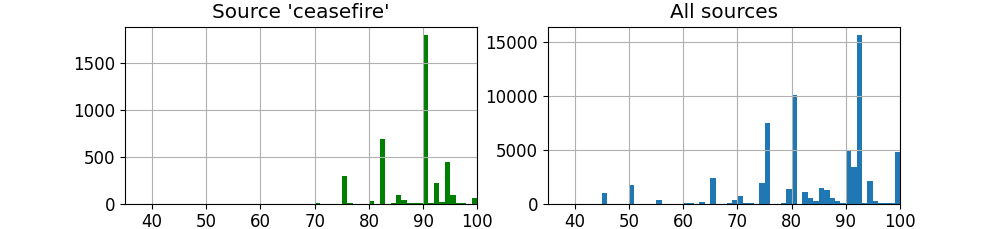

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
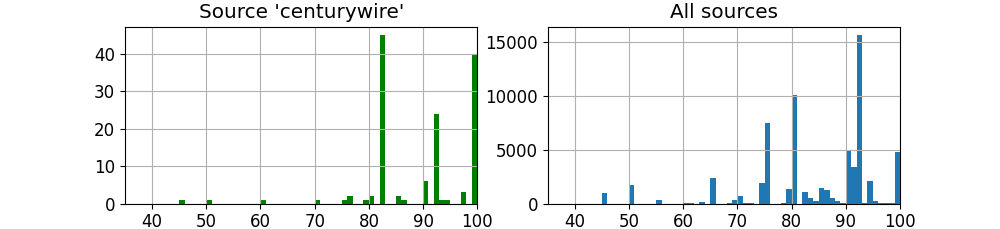

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
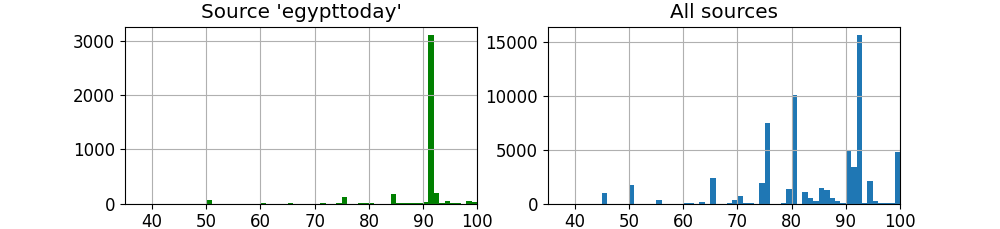

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
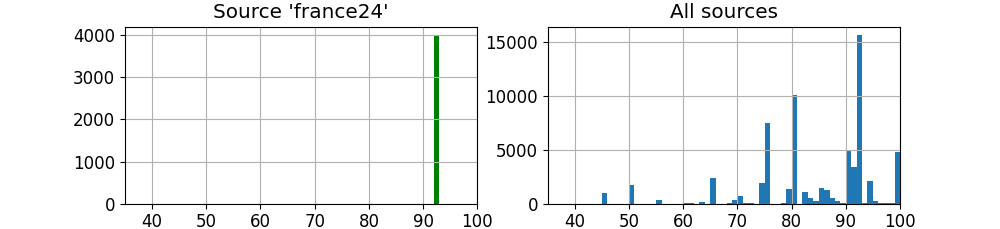

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
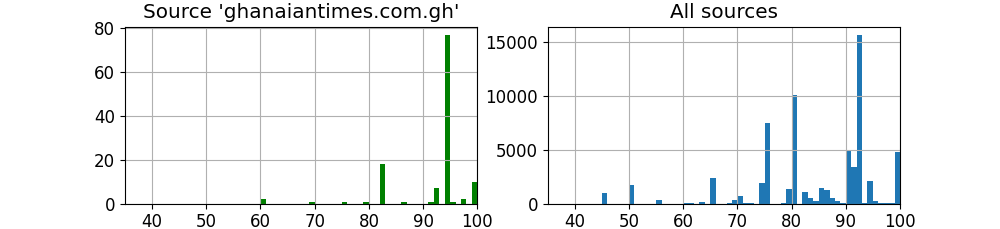

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
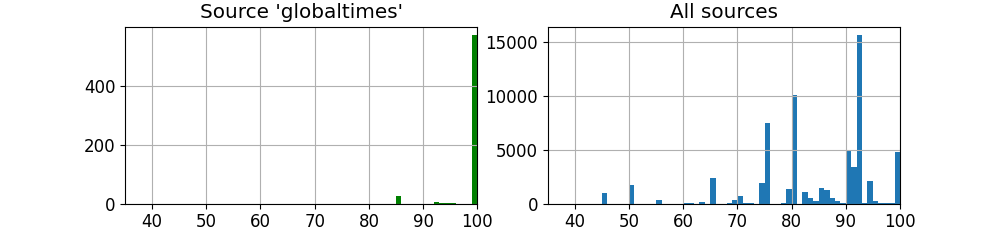

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
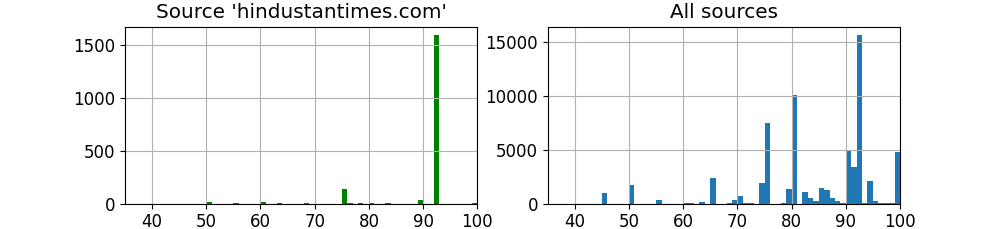

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
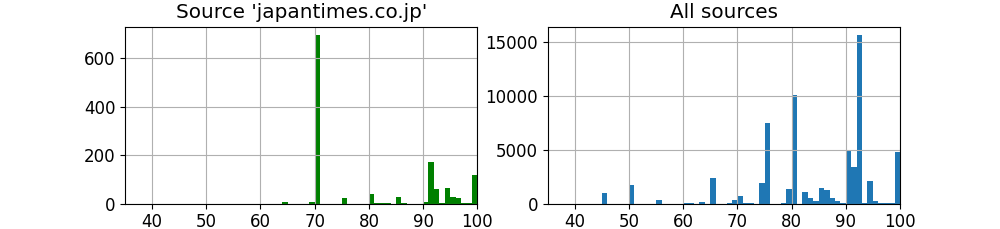

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
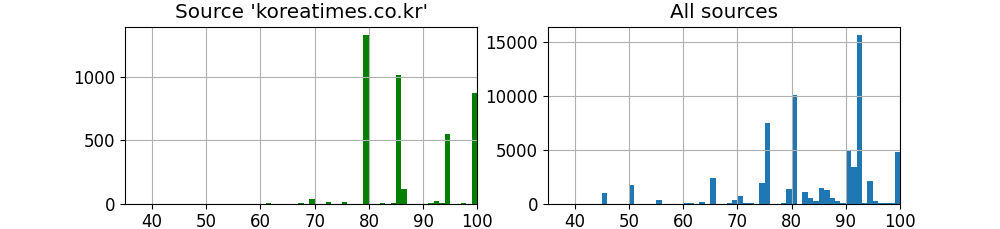

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
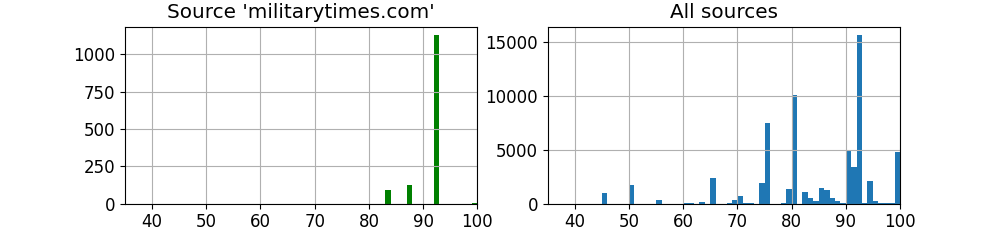

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
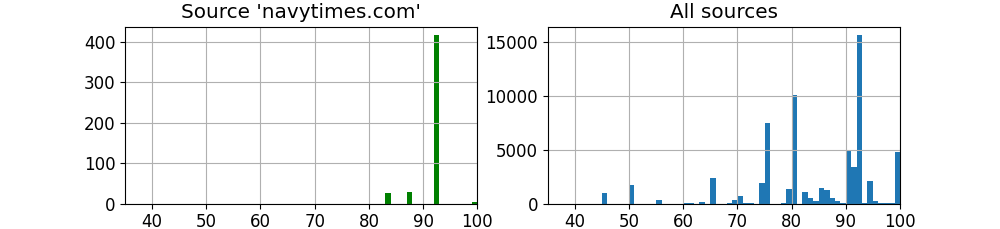

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
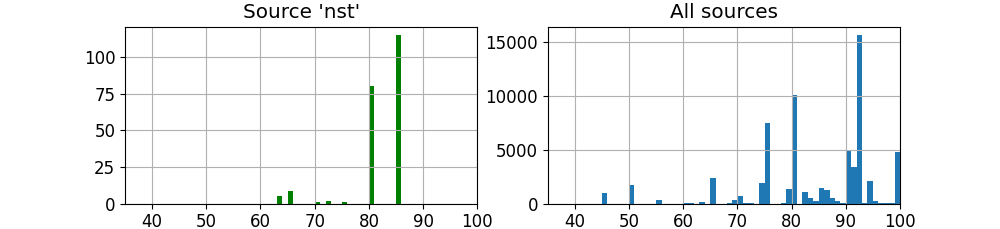

/tmp/ipykernel_689/513192040.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,2.3))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
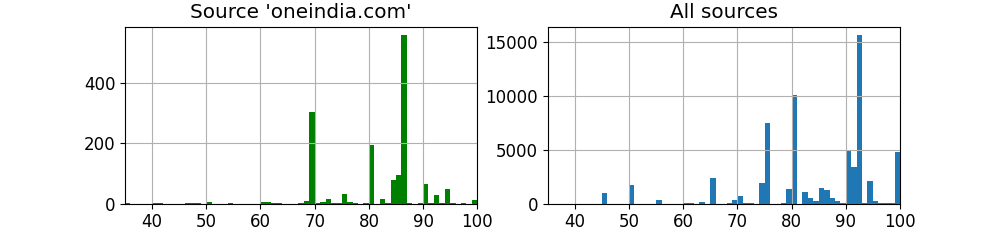

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
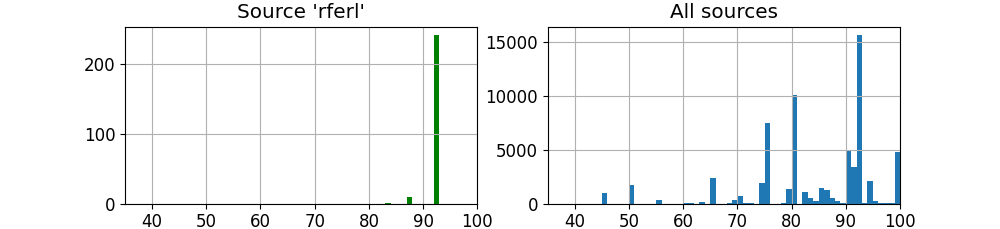

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
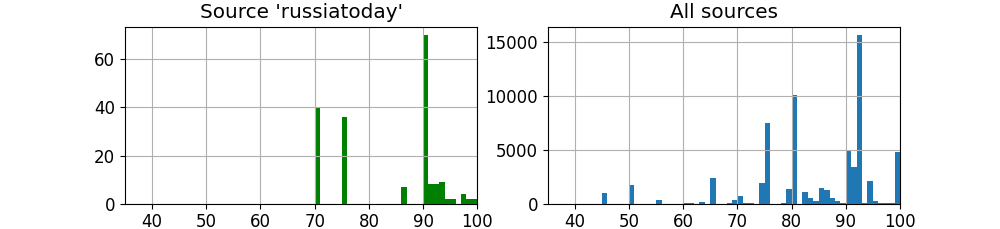

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
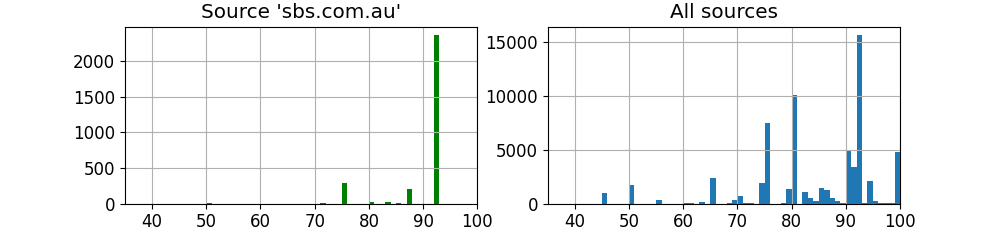

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
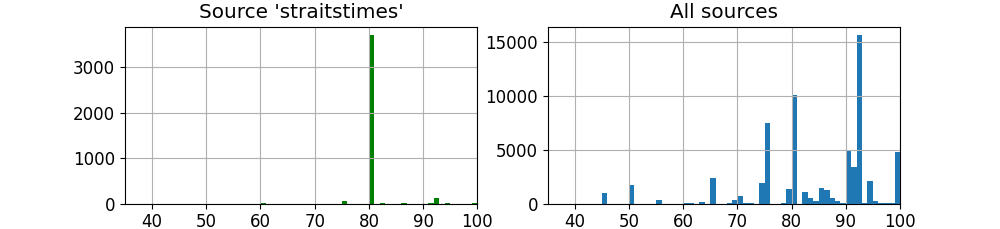

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
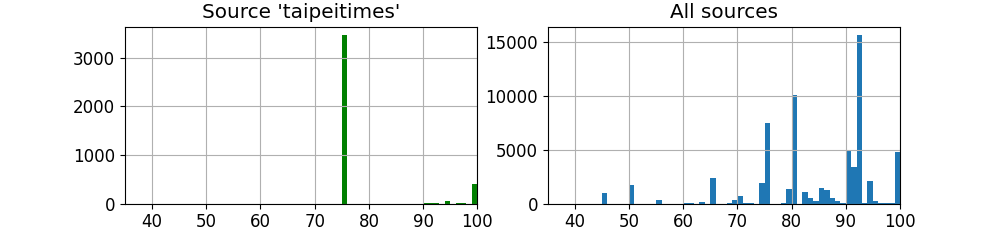

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
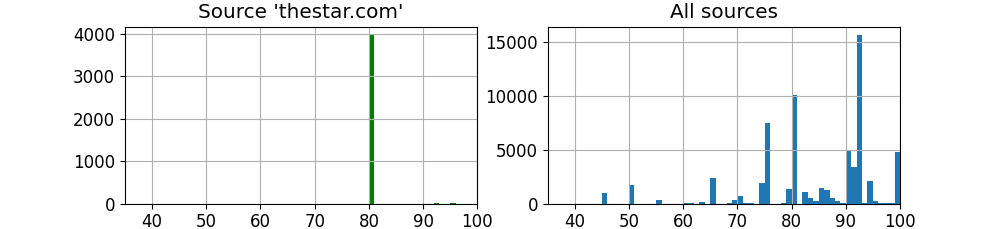

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
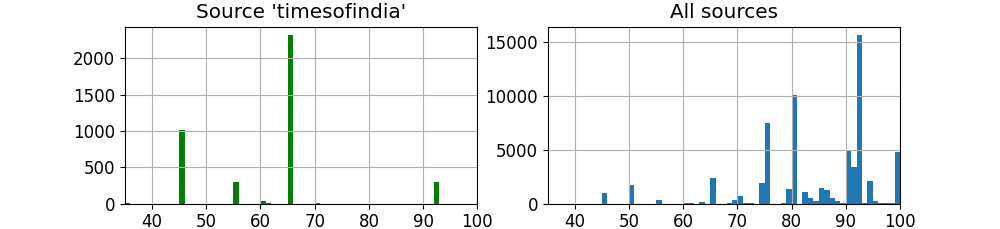

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
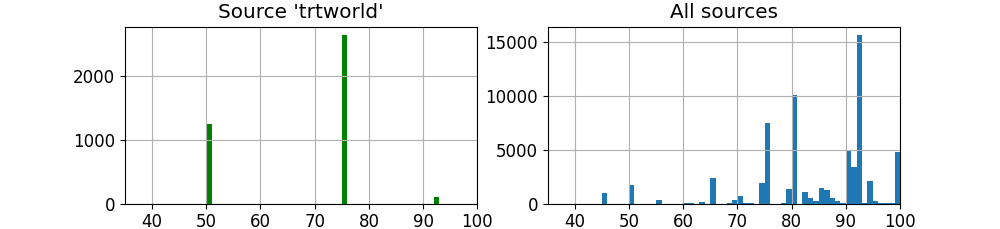

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
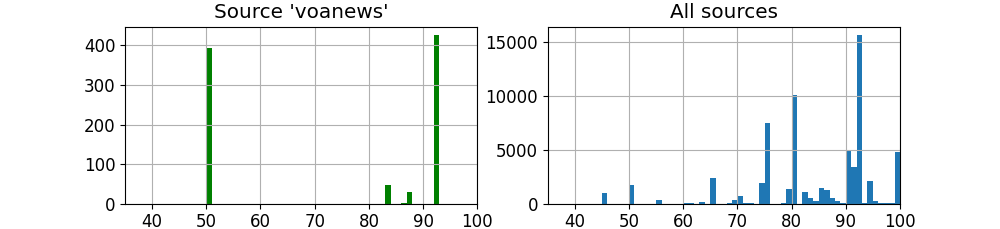

In [15]:
bins=np.arange(1,101,1)

os.makedirs(os.path.join(RESULTS_FOLDER,"histograms"), exist_ok=True)

for indx_src_to_plot in range(len(sources)):
#   plt.figure(figsize=(10,4))
  plt.figure(figsize=(10,2.3))
  plt.subplot(1,2,1)
  df.loc[df['source']==sources[indx_src_to_plot], 'compression'].hist(bins=bins, color='green')
  plt.xlim(35, 100)
  plt.title("Source '{}'".format(sources[indx_src_to_plot]))
  plt.xlabel("Compression quality level")
  
  plt.subplot(1,2,2)
  df['compression'].hist(bins=bins)
  plt.xlim(35, 100)
  plt.title("All sources")
  plt.xlabel("Compression quality level")
  plt.rcParams['font.size'] = '12'
  plt.show()
  #uncomment to save:
  src = sources[indx_src_to_plot]
  plt.savefig(os.path.join(RESULTS_FOLDER,"histograms", "cl_{}_vs_all.pdf".format(src)), bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
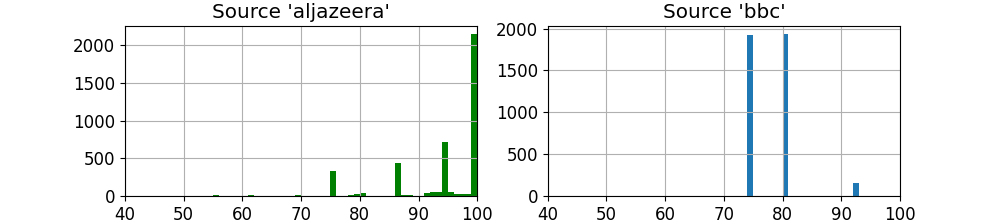

In [16]:
bins=np.arange(1,101,1)

# plt.figure(figsize=(10,4))
plt.figure(figsize=(10,2.2))
plt.subplot(1,2,1)
df.loc[df['source']=='aljazeera', 'compression'].hist(bins=bins, color='green')
plt.xlim(40, 100)
plt.title("Source '{}'".format('aljazeera'))
plt.xlabel("Compression quality level")

plt.subplot(1,2,2)
df.loc[df['source']=='bbc', 'compression'].hist(bins=bins, color='tab:blue')
plt.xlim(40, 100)
plt.title("Source '{}'".format('bbc'))
plt.xlabel("Compression quality level")
plt.rcParams['font.size'] = '12'
plt.show()
plt.savefig(os.path.join(RESULTS_FOLDER,"histograms", "cl_aljazeera_vs_bbc.pdf"), bbox_inches='tight')

###  Note: above shows why it's easy to differentiate bbc from aljazeera: little overlap between compression level histograms.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
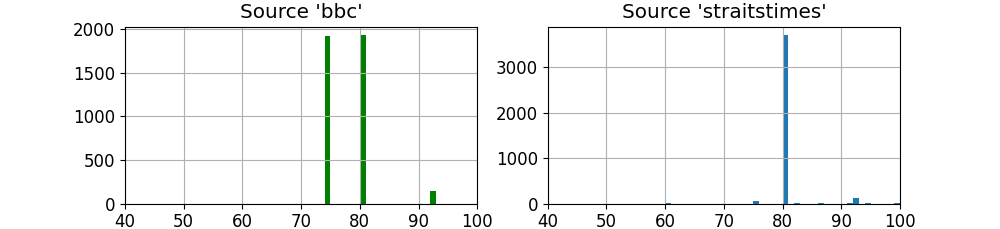

In [17]:
bins=np.arange(1,101,1)

# plt.figure(figsize=(10,4))
plt.figure(figsize=(10,2.3))
plt.subplot(1,2,1)
df.loc[df['source']=='bbc', 'compression'].hist(bins=bins, color='green')
plt.xlim(40, 100)
plt.title("Source '{}'".format('bbc'))
plt.xlabel("Compression quality level")

plt.subplot(1,2,2)
df.loc[df['source']=='straitstimes', 'compression'].hist(bins=bins, color='tab:blue')
plt.xlim(40, 100)
plt.title("Source '{}'".format('straitstimes'))
plt.xlabel("Compression quality level")
plt.rcParams['font.size'] = '12'
plt.show()
plt.savefig(os.path.join(RESULTS_FOLDER,"histograms", "cl_bbc_vs_straitstimes.pdf"), bbox_inches='tight')

### Note: this illustates why straitstimes and bbc are easily confused --> use very similar compression settings, particularly 80.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
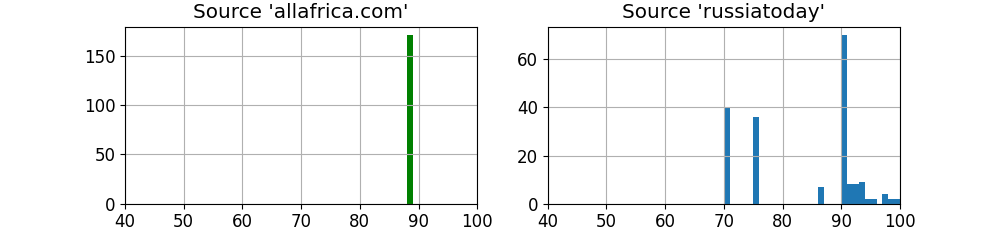

In [18]:
bins=np.arange(1,101,1)

# plt.figure(figsize=(10,4))
plt.figure(figsize=(10,2.3))
plt.subplot(1,2,1)
df.loc[df['source']=='allafrica.com', 'compression'].hist(bins=bins, color='green')
plt.xlim(40, 100)
plt.title("Source '{}'".format('allafrica.com'))
plt.xlabel("Compression quality level")

plt.subplot(1,2,2)
df.loc[df['source']=='russiatoday', 'compression'].hist(bins=bins, color='tab:blue')
plt.xlim(40, 100)
plt.title("Source '{}'".format('russiatoday'))
plt.xlabel("Compression quality level")
plt.rcParams['font.size'] = '12'
plt.show()
plt.savefig(os.path.join(RESULTS_FOLDER,"histograms", "cl_allafrica_vs_russiatoday.pdf"), bbox_inches='tight')

### Note: 
AllofAfrica has great performance because it has very distinctive compression levels.  
Russia today has poor performance for two reasons:
1. Non-distinct compression
1. Small number of samples, likely reduces ability to learn the full distribution of values employed by the site.

In [19]:
df[df['compression']==92]['q_name'].value_counts()

webp_092          12801
png_092            2168
gif_092             321
jpeg_092_3e0f1       87
jpeg_092_66c51       54
jpeg_092_4054c       42
jpeg_092_80c29       27
jpeg_092_f1408       25
jpeg_092_56f7c       22
jpeg_092_b9733       21
jpeg_092_37f5f       21
jpeg_092_9deb2       10
jpeg_092_4fec2        9
jpeg_092_843fb        8
jpeg_092_81bfd        8
jpeg_092_049ca        6
jpeg_092_2afb8        4
jpeg_092_bc451        2
jpeg_092_bb02c        2
jpeg_092_1ee26        2
jpeg_092_14704        2
jpeg_092_219f8        1
jpeg_092_2dd0f        1
jpeg_092_3e832        1
jpeg_092_e3d53        1
jpeg_092_0e478        1
jpeg_092_02d9a        1
jpeg_092_3e1f8        1
jpeg_092_f5478        1
Name: q_name, dtype: int64

### Note:
This shows that advanced features (including a hash of quantization tables, and file format) allows differentiation of many different image settings which all share compression quality level 92.

# Experiment 1:

Do a source verification experiment, asking "Is the image from the claimed source, or not?"
Randomly sample articles, by URL. Limit imbalance in the test dataset.

In [20]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import IsolationForest
#Guide to LabelEncoder:  
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html


#create numerical class labels for quantization categorical names (suitable for 
#use as  ML training feature vector)
le_qs = preprocessing.LabelEncoder()
le_qs.fit(df['q_name'])
df['q_name_class'] = le_qs.transform(df['q_name'])

sources = sorted(list(df['source'].unique()))
le_sources = preprocessing.LabelEncoder()
le_sources.fit(sources)
df['source_class'] = le_sources.transform(df['source'])

In [21]:
df

articleUrl                                                       articleHash                                                                                                                                                           imageUrl      source        mime  compression                            q_hash          q_name            timestamp  q_name_class  source_class
0                     https://www.abc.net.au/news/2020-05-25/toowoomba-unemployment-hits-horrific-level/12282346                                  4de7b04b17622bc838468486216f9878      https://live-production.wcms.abc-cdn.net.au/10d55dfa1fef3ec5f4f20cdac0b64df5?impolicy=wcms_crop_resize&cropH=528&cropW=938&xPos=1&yPos=0&width=862&height=485  abc.net.au  image/webp           92                               NaN        webp_092  2020-05-25 00:00:00           254             0
1      https://www.abc.net.au/news/2017-01-11/trade-war-between-us-and-china-a-major-threat-to-australia/8172562                                  99770eadd0f12e1c63df525a8c739f8c    https://live-production.wcms.abc-cdn.net.au/bcbaa4880d63e1b7c46ac95773583381?impolicy=wcms_crop_resize&cropH=1037&cropW=1851&xPos=0&yPos=0&width=862&height=485  abc.net.au  image/webp           92                               NaN        webp_092  2017-01-11 00:00:00           254             0
2              https://www.abc.net.au/news/2021-01-31/trainee-guide-dogs-go-for-test-runs-with-handlers/13107128                                  90c0fcf3f9dd12d2770ac4092ca9f612    https://live-production.wcms.abc-cdn.net.au/28314158cc17db94d2062a7539d49fd9?impolicy=wcms_crop_resize&cropH=1515&cropW=2272&xPos=0&yPos=0&width=862&height=575  abc.net.au  image/webp           92                               NaN        webp_092  2021-01-31 00:00:00           254             0
3              https://www.abc.net.au/news/2021-01-31/trainee-guide-dogs-go-for-test-runs-with-handlers/13107128                                  90c0fcf3f9dd12d2770ac4092ca9f612  https://live-production.wcms.abc-cdn.net.au/be7013fd935ad10ecd612700c2973c9b?impolicy=wcms_crop_resize&cropH=2250&cropW=2250&xPos=375&yPos=0&width=862&height=862  abc.net.au  image/webp           92                               NaN        webp_092  2021-01-31 00:00:00           254             0
4              https://www.abc.net.au/news/2021-01-31/trainee-guide-dogs-go-for-test-runs-with-handlers/13107128                                  90c0fcf3f9dd12d2770ac4092ca9f612    https://live-production.wcms.abc-cdn.net.au/b639a168ddb98a55e2c46628278f6063?impolicy=wcms_crop_resize&cropH=2001&cropW=3000&xPos=0&yPos=0&width=862&height=575  abc.net.au  image/webp           92                               NaN        webp_092  2021-01-31 00:00:00           254             0
...                                                                                                          ...                                                               ...                                                                                                                                                                ...         ...         ...          ...                               ...             ...                  ...           ...           ...
64680                    https://www.voanews.com/usa/police-ohio-city-pledge-thorough-probe-black-teens-shooting  59bf6d29b76b4ecb4f52770f5d0f83db350da788309498666ca0a9ebfcb6bcb5                                          https://im-media.voltron.voanews.com/Drupal/01live-166/styles/892x501/s3/2019-04/DC772857-F881-4A9E-B36A-B693023E9514.jpg     voanews  image/jpeg           50  48c9be01d998be93be725587386b3028  jpeg_050_48c9b  2016-09-15 18:20:00            13            29
64681                    https://www.voanews.com/usa/police-ohio-city-pledge-thorough-probe-black-teens-shooting  59bf6d29b76b4ecb4f52770f5d0f83db350da788309498666ca0a9ebfcb6bcb5                 https://im-media.voltron.voanews.com/Drupal/01live-166/styles/sourced_737px_wide/s3

## Sample data to form train and test splits, then compute results.
Notes: We sample on articles, not images, since articles may have multiple images, and we want to keep images from the same article together since they may share compression settings, and we want to prevent data leakage from between the train and test splits.  For each experiment, we use 40% of articles from a source for testing.  We sample an equal # of articles not from the source to include in the test set too, so the data is roughly blanced between positive and negative examples.  (The # of articles from a source vs not the source is exactly balanced; the number of images is only roughly blanced.) Having a balance between positive and negative samples in the test set ensures that ROC curves are meaningful.  The remaining data is used for training. 

We repeat each experiment (with random sampling) 5 times to help quantify the uncertainty.  (This is similar to Shuffle Split, which differs from K-fold cross validation.)  

Note: the models technically compute the Log-likelihood ratio, referred to as LLR in the cell below.  That is not important for understanding the results -- here we simply use the LLR score as the classifer score to create the ROC curve.

Procedure:
1. Randomly sample 40% of articles from a source.
1. Randomly sample equal number of articles not from the source. Those two form the test set, which is roughly balanced.
1. All remaining data constitute the training data.

In [22]:
#Prepare Train and Test Split.
#Do random sampling to make train/test split. 
PERCENT_TEST = 0.40

all_q_name_vals = sorted(df['q_name'].unique())

#Sample from articles (so we can keep images from articles grouped together)
df_articles = df[['articleHash', 'source', 'source_class']].drop_duplicates()

NUM_TRIALS = 5
results_per_trial_cl = {}
results_per_trial_qm = {}

for trial in tqdm(range(NUM_TRIALS)):

  numsamples_balanced_testset=[]
  AUCs_cl = []
  AUCs_qm = []

  results_cl={}
  results_qm={}

  for source in sources:

    #-----------------------------------
    #Form train/test data split

    #get all articles from the source, or not from the source
    df_articles_from_source = df_articles[df_articles['source']==source]
    df_articles_not_from_source = df_articles[df_articles['source']!=source]

    #Randomly sample articles to build test set, e.g. 40% of articles from the source:
    num_test_articles_from_source = int(PERCENT_TEST*len(df_articles_from_source))
    df_test_articles_from_source = df_articles_from_source.sample(num_test_articles_from_source)
    #then sample equal number of articles not from the source
    df_test_articles_not_from_source = df_articles_not_from_source.sample(num_test_articles_from_source)
    df_test_articles = pd.concat([df_test_articles_from_source, df_test_articles_not_from_source])

    df_train_articles = df_articles[ ~df_articles['articleHash'].isin(df_test_articles['articleHash'])]


    #Get all images articles in train/test splits:
    df_train = df[ df['articleHash'].isin(df_train_articles['articleHash']) ].reset_index()
    df_test = df[ df['articleHash'].isin(df_test_articles['articleHash']) ].reset_index()

    #Set ground truth label: 1 if image misattributed, else 0
    df_test['is_misattributed'] = np.array(df_test['source']!=source, dtype=int)

    #-----------------------------------
    #Fit models

    #Naive Bayes model using only compression levels as features
    cl_model = compr_levels.attribution_compression_levels()
    cl_model.fit(df[['source', 'compression']])
    
    #Naive Bayes model with features consisting of file type, compression level, quantization matrices
    qm_model = quant_matrices.attribution_quant_matrices()
    qm_model.fit(df_train[['source', 'q_name']], compr_category_names=all_q_name_vals)
    

    #-----------------------------------
    #prediction on test set
    claimed_source_list = [source]*len(df_test)

    LLRs_isfake_cl, probs_fromsource_cl, probs_notfromsource_cl, _ = \
      cl_model.predict(df_test['compression'], claimed_source_list)
    df_test['LLR_cl'] = LLRs_isfake_cl
    
    #Determine if prediction is wrong
    misclassified_cl = (df_test['is_misattributed'] - .5) * LLRs_isfake_cl < 0
    df_test['misclassified_cl'] = misclassified_cl
    #----------
    
    LLRs_isfake_qm, probs_fromsource_qm, probs_notfromsource_qm, \
      unrecognized_sources_qm = qm_model.predict(df_test['q_name'], claimed_source_list)
    df_test['LLR_qm'] = LLRs_isfake_qm

    #Determine if prediction is wrong
    misclassified_qm = (df_test['is_misattributed'] - .5) * LLRs_isfake_qm < 0
    df_test['misclassified_qm'] = misclassified_qm

    #-----------------------------------
    #Use hypothesis test score to plot ROC curve for this source:
    
    numsamples_balanced_testset.append(len(df_test))
    
    fpr, tpr, thresholds = roc_curve(df_test['is_misattributed'], df_test['LLR_cl'], pos_label=1)
    roc_auc = auc(fpr, tpr)
    AUCs_cl.append(roc_auc)
    
    results_cl[source] = {'source': source, 'fpr': fpr, 'tpr':tpr, 
                       'auc':roc_auc, 'numsamples':len(df_test),
                       'scores_isfake': df_test['LLR_cl'],
                       'label_isfake': df_test['is_misattributed'],
                       'df_test':df_test}
    results_per_trial_cl[trial] = results_cl
    
    #-----------
    fpr, tpr, thresholds = roc_curve(df_test['is_misattributed'], df_test['LLR_qm'], pos_label=1)
    roc_auc = auc(fpr, tpr)
    AUCs_qm.append(roc_auc)
    
    results_qm[source] = {'source': source, 'fpr': fpr, 'tpr':tpr, 
                       'auc':roc_auc, 'numsamples':len(df_test),
                       'scores_isfake': df_test['LLR_qm'],
                       'label_isfake': df_test['is_misattributed'],
                       'df_test':df_test}
    results_per_trial_qm[trial] = results_qm


  0%|          | 0/5 [00:00<?, ?it/s]

In [23]:
#Compute summaries of results

FPR_THRESHOLD = 0.005  # compute TPR @ this FPR = 0.5%

numsamples_balanced_testset = []

AUCs_mean_cl = []
AUCs_std_cl = []
tpr_at_fpr_mean_cl = []

AUCs_mean_qm = []
AUCs_std_qm = []
tpr_at_fpr_mean_qm = []

#compression levels cl
for source in sources:
  AUCs_per_trial = []
  tpr_per_trial = []
  fpr_per_trial = []
  tprs_at_fpr_threshold = []
  for trial in range(NUM_TRIALS):
    AUCs_per_trial.append(results_per_trial_cl[trial][source]['auc'])
    fpr = results_per_trial_cl[trial][source]['fpr']
    tpr = results_per_trial_cl[trial][source]['tpr']
    fpr_per_trial.append(fpr)
    tpr_per_trial.append(tpr)
    tprs_at_fpr_threshold.append( np.interp(FPR_THRESHOLD, fpr, tpr) )
  AUCs_mean_cl.append(np.mean(AUCs_per_trial))
  AUCs_std_cl.append(np.std(AUCs_per_trial))
  tpr_at_fpr_mean_cl.append(np.mean(tprs_at_fpr_threshold))
  
  numsamples_balanced_testset.append(results_per_trial_qm[trial][source]['numsamples'])

#quantization matrices qm
for source in sources:
  AUCs_per_trial = []
  tpr_per_trial = []
  fpr_per_trial = []
  tprs_at_fpr_threshold = []
  for trial in range(NUM_TRIALS):
    AUCs_per_trial.append(results_per_trial_qm[trial][source]['auc'])
    fpr = results_per_trial_qm[trial][source]['fpr']
    tpr = results_per_trial_qm[trial][source]['tpr']
    fpr_per_trial.append(fpr)
    tpr_per_trial.append(tpr)
    tprs_at_fpr_threshold.append( np.interp(FPR_THRESHOLD, fpr, tpr) )
  AUCs_mean_qm.append(np.mean(AUCs_per_trial))
  AUCs_std_qm.append(np.std(AUCs_per_trial))
  tpr_at_fpr_mean_qm.append(np.mean(tprs_at_fpr_threshold))
  
df_summary = pd.DataFrame({'source':sources, 'test_size':numsamples_balanced_testset,
  'AUC_mean_cl':AUCs_mean_cl, 'AUC_std_cl':AUCs_std_cl, 
  'tpr_at_fpr_mean_cl':tpr_at_fpr_mean_cl,                 
  'AUC_mean_qm':AUCs_mean_qm, 'AUC_std_qm':AUCs_std_qm, 
  'tpr_at_fpr_mean_qm':tpr_at_fpr_mean_qm,                         
  } )
df_summary

df_summary['AUC_mean_diff'] = df_summary['AUC_mean_qm'] - df_summary['AUC_mean_cl']
df_summary['tpr_at_fpr_mean_diff'] = df_summary['tpr_at_fpr_mean_qm'] - df_summary['tpr_at_fpr_mean_cl']

In [24]:
df_summary

source  test_size  AUC_mean_cl  AUC_std_cl  tpr_at_fpr_mean_cl  AUC_mean_qm  AUC_std_qm  tpr_at_fpr_mean_qm  AUC_mean_diff  tpr_at_fpr_mean_diff
0             abc.net.au       3196     0.890340    0.002833            0.517283     0.901784    0.003605            0.411352       0.011444             -0.105931
1      airforcetimes.com        452     0.864762    0.016849            0.694771     0.866129    0.013204            0.559096       0.001368             -0.135675
2              aljazeera       2110     0.944326    0.010901            0.358819     0.956332    0.010412            0.511077       0.012006              0.152258
3          allafrica.com        199     1.000000    0.000000            1.000000     1.000000    0.000000            1.000000       0.000000              0.000000
4      americanfreepress        631     0.945467    0.008200            0.345792     0.965780    0.008514            0.559886       0.020314              0.214095
5              asahi.com        469     0.947233    0.006847            0.638772     0.948378    0.008006            0.907852       0.001145              0.269081
6                    bbc       1910     0.960054    0.013814            0.595135     0.963705    0.012271            0.818741       0.003650              0.223606
7      canadiandimension       2587     0.953285    0.005101            0.676572     0.967643    0.006656            0.882839       0.014358              0.206267
8              ceasefire       2178     0.908125    0.015439            0.220775     0.932204    0.008087            0.499606       0.024079              0.278831
9            centurywire         99     0.878501    0.040893            0.169902     0.907435    0.029713            0.272527       0.028934              0.102625
10            egypttoday       4128     0.949971    0.001610            0.217132     0.980957    0.001043            0.487207       0.030987              0.270075
11              france24       4392     0.905254    0.003734            0.811669     0.918677    0.006689            0.818093       0.013424              0.006425
12  ghanaiantimes.com.gh        172     0.942966    0.026669            0.362601     0.962048    0.022159            0.710997       0.019082              0.348396
13           globaltimes        572     0.968107    0.020745            0.618704     0.981610    0.013116            0.775567       0.013504              0.156863
14    hindustantimes.com       2270     0.877038    0.010754            0.613829     0.907767    0.009787            0.674163       0.030729              0.060334
15      japantimes.co.jp       1272     0.926657    0.008465            0.214347     0.959599    0.004216            0.440004       0.032942              0.225657
16      koreatimes.co.kr       3784     0.976719    0.002383            0.623557     0.987903    0.001531            0.845399       0.011184              0.221841
17     militarytimes.com       1554     0.887058    0.011152            0.747147     0.893644    0.019678            0.773923       0.006586              0.026776
18         navytimes.com        540     0.884810    0.022274            0.720833     0.892527    0.023951            0.676303       0.007717             -0.044530
19                   nst        178     0.945641    0.034901            0.705736     0.938655    0.031094            0.646258      -0.006986             -0.059478
20          oneindia.com       1756     0.932711    0.008091            0.212092     0.942363    0.005263            0.427372       0.009652              0.215280
21                 rferl        232     0.849076    0.020829            0.696838     0.839250    0.018408            0.661759      -0.009826             -0.035080
22           russiatoday        297     0.887464    0.033983            0.341932     0.882372    0.038438            0.564842      -0.005092              0.222910
23            sbs.com.au       1736     0.864952    0.015398            0.521946     0.888649    0.009574 

## Plot single roc curves with uncertainty bands, using model that includes quantization matrices as features,

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
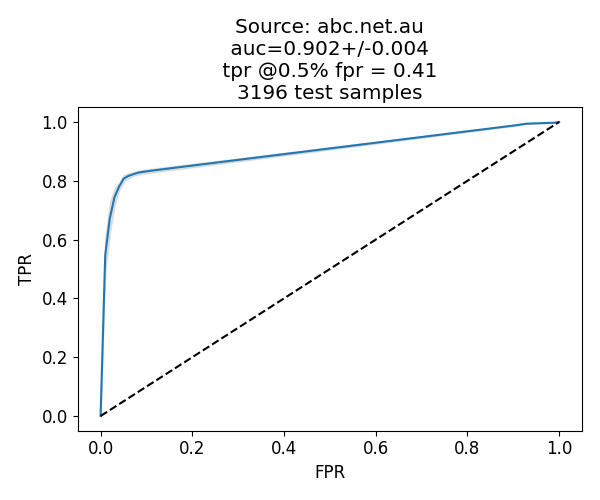

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
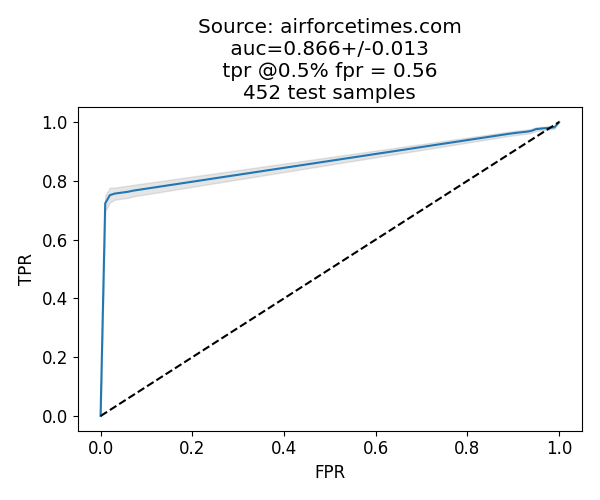

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
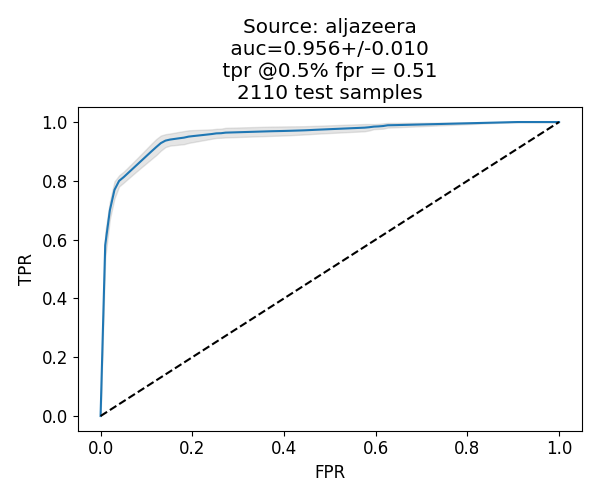

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
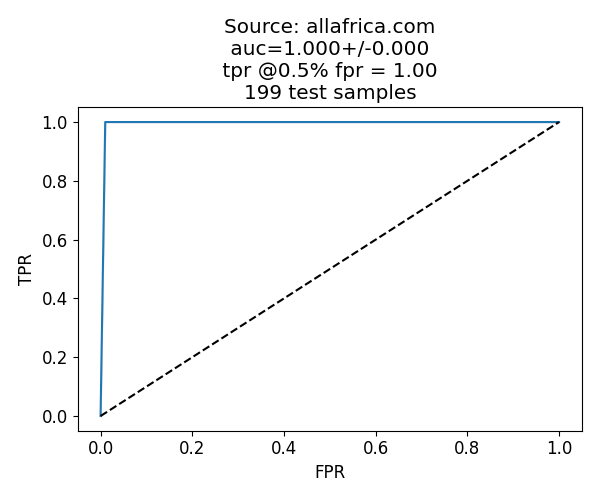

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
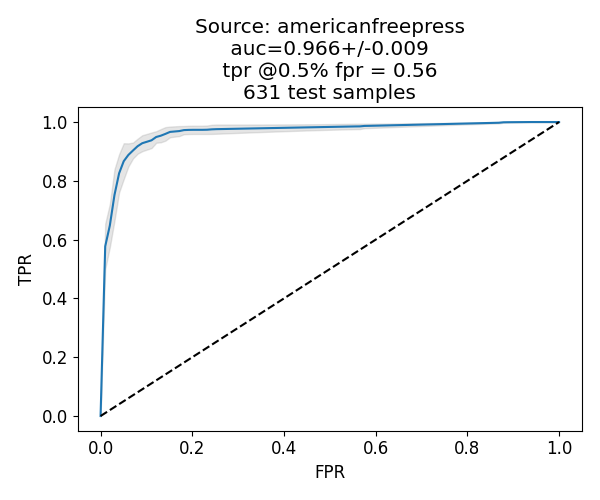

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
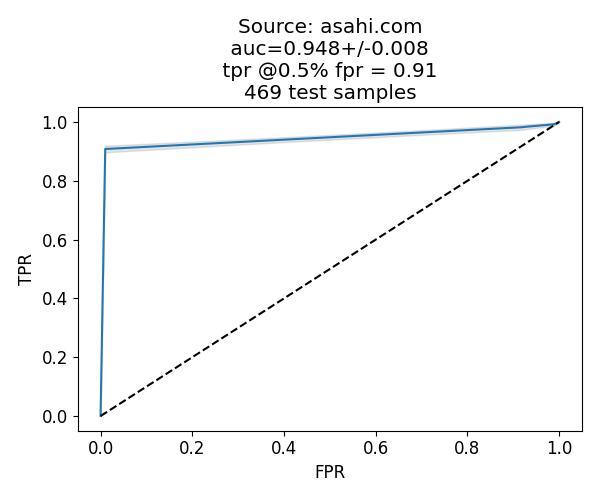

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
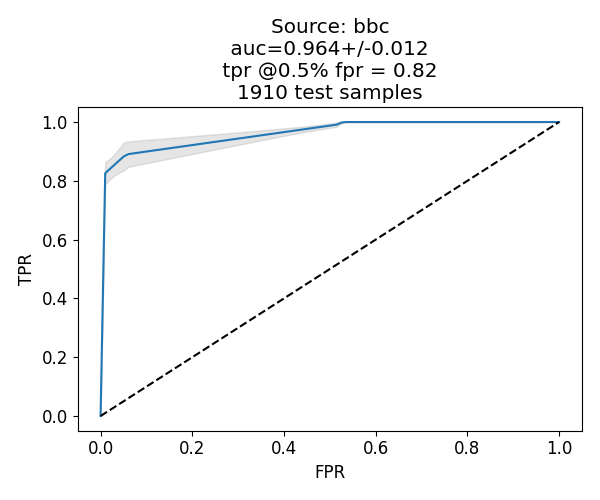

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
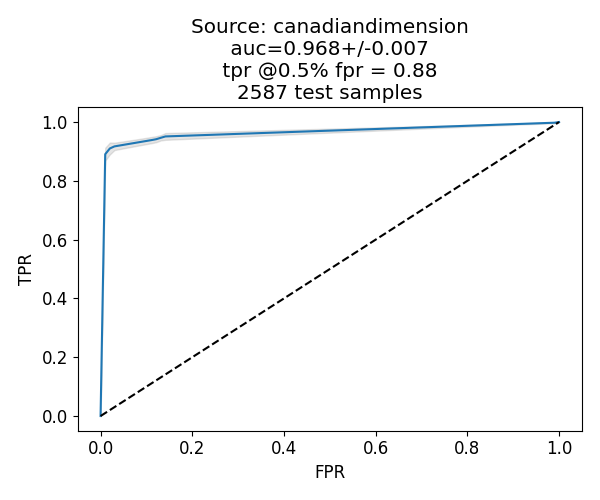

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
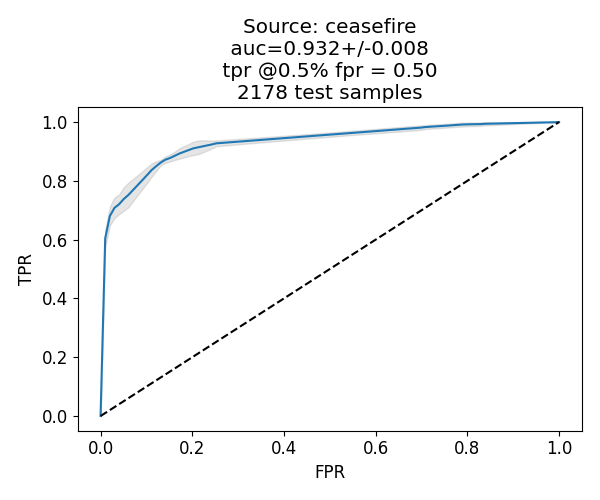

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
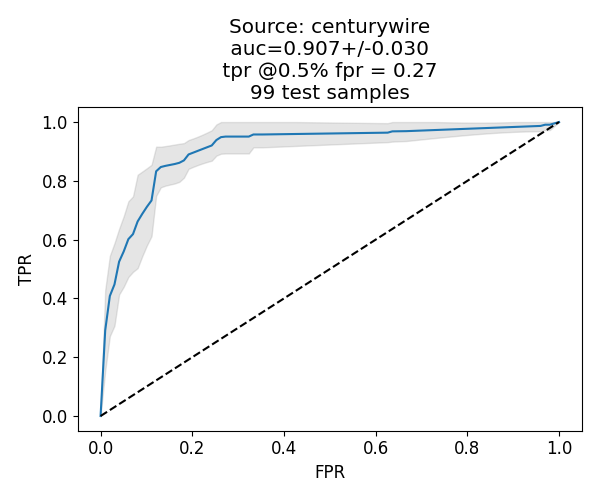

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
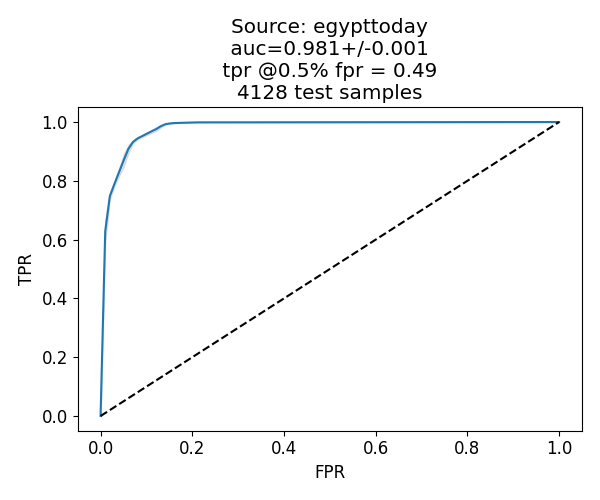

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
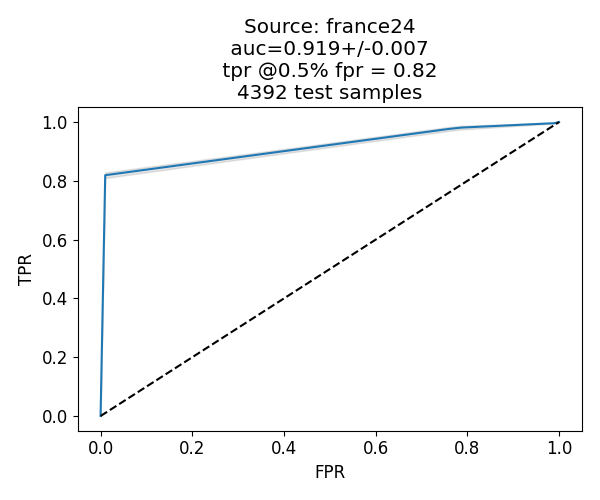

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
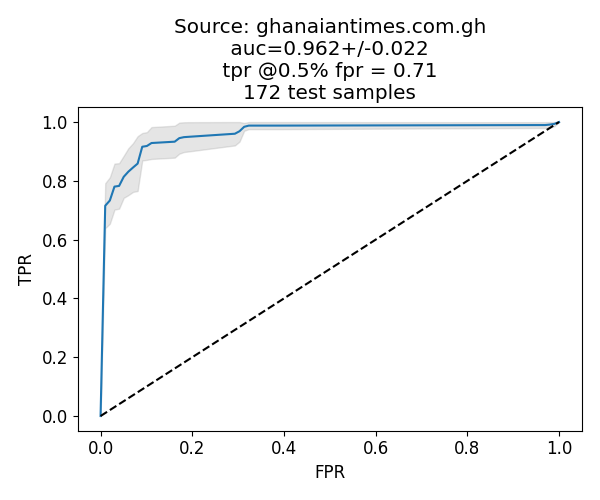

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
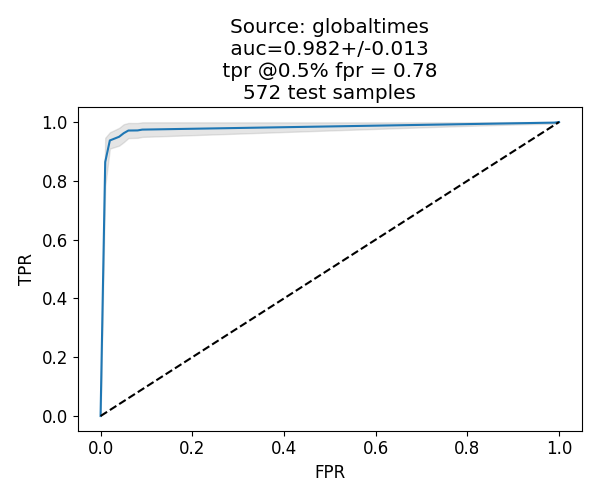

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
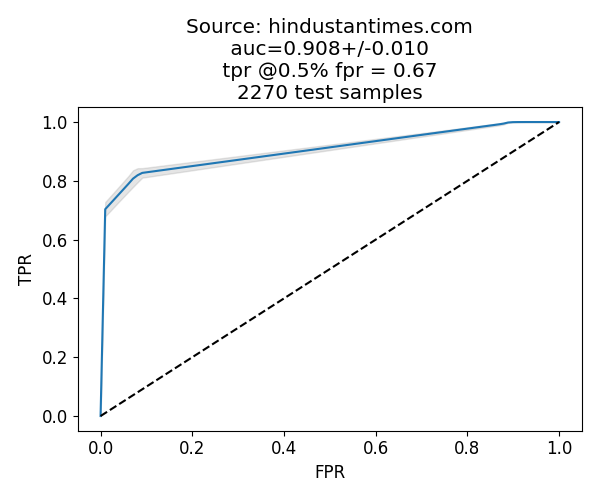

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
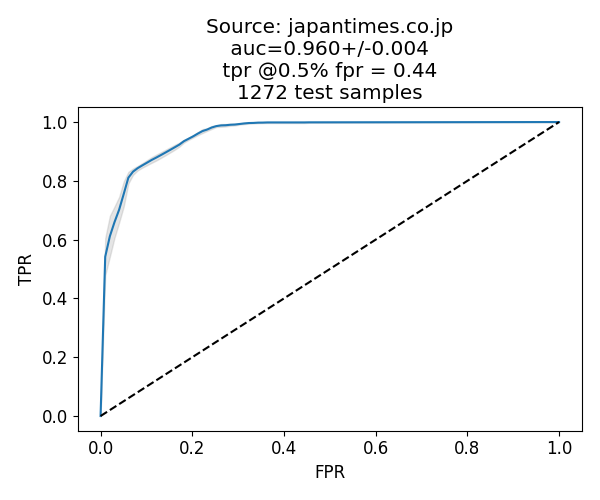

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
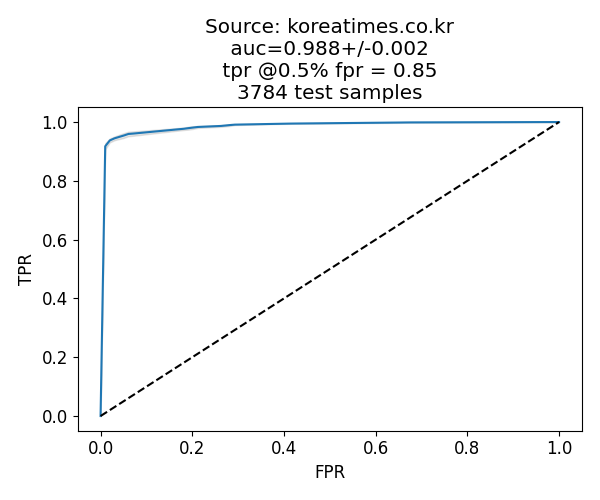

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
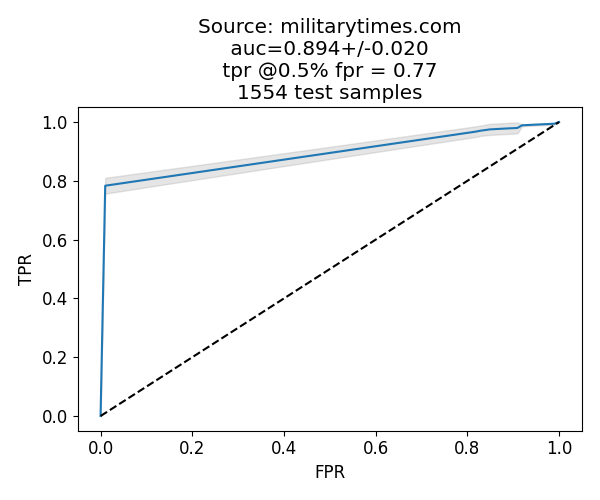

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
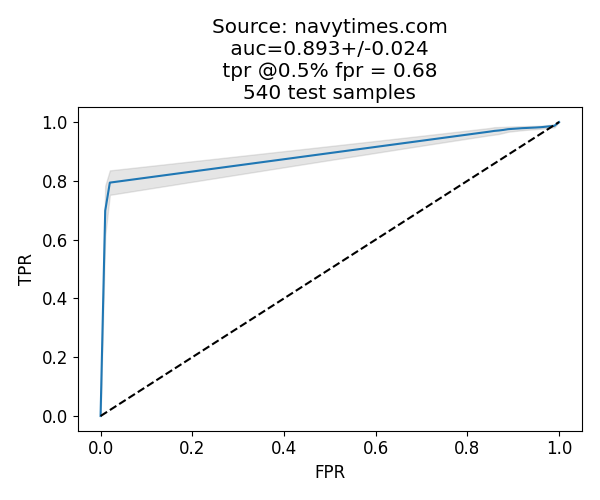

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
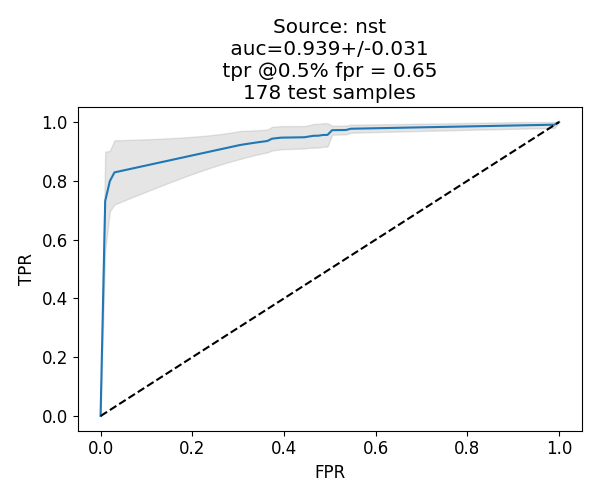

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
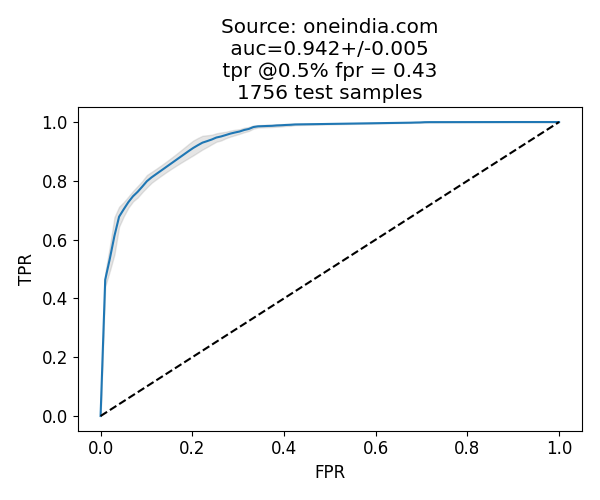

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
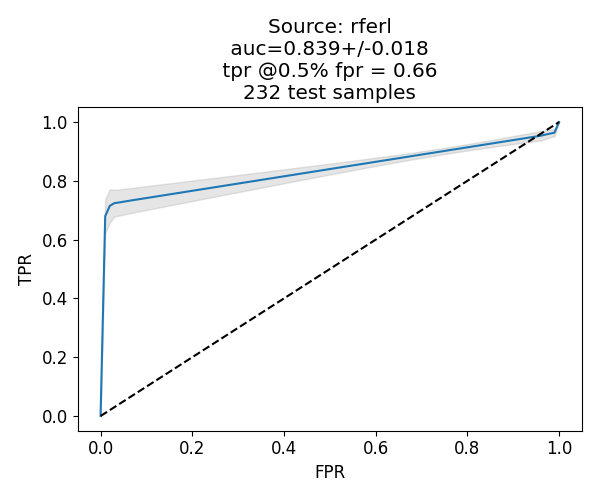

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
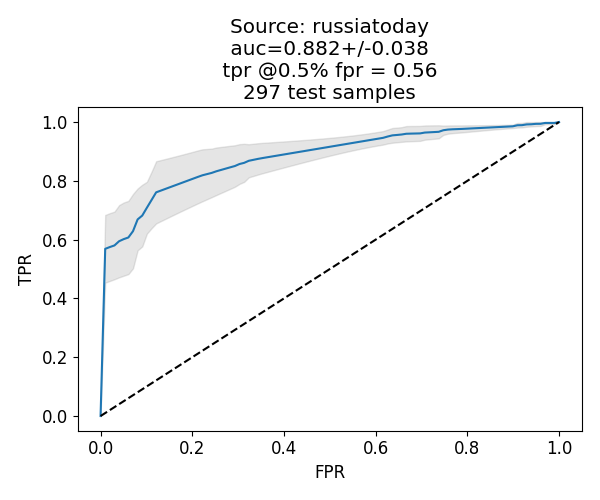

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
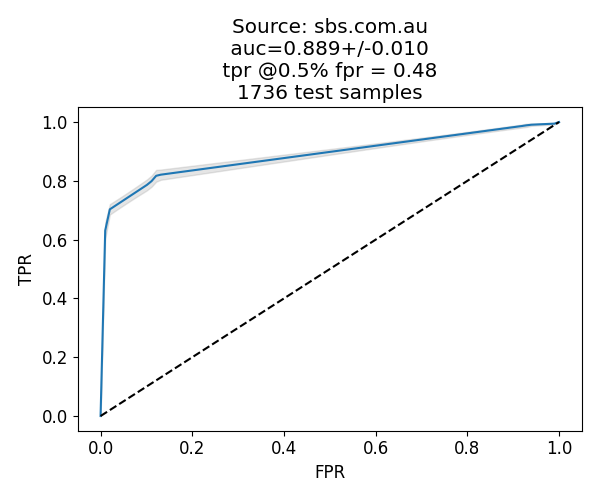

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
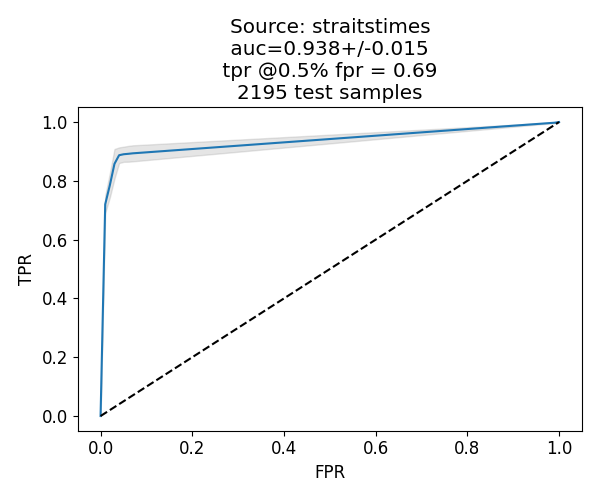

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
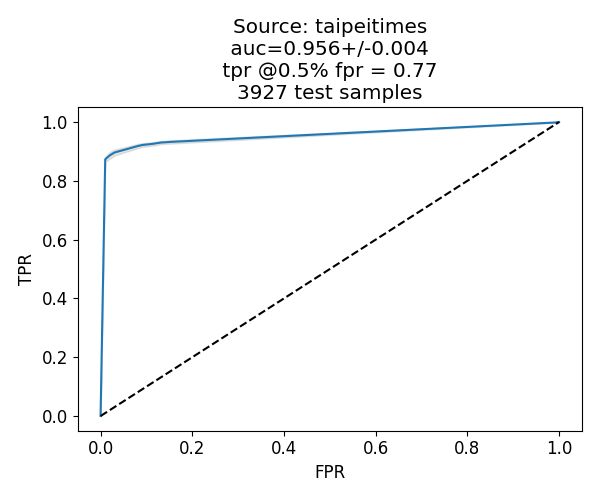

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
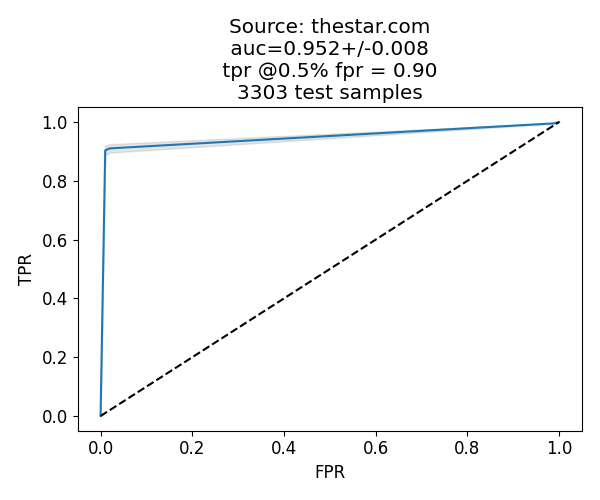

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
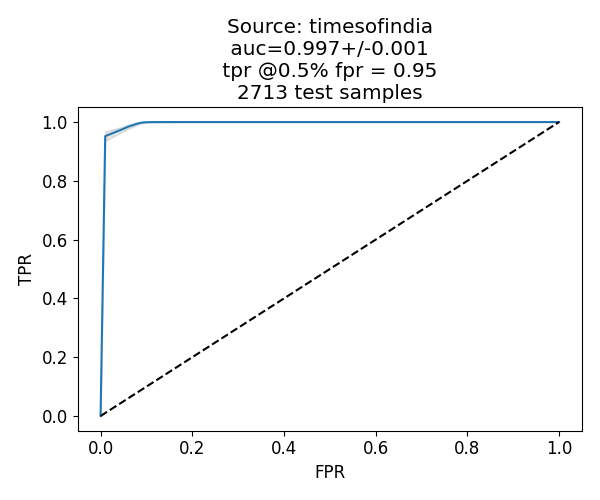

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
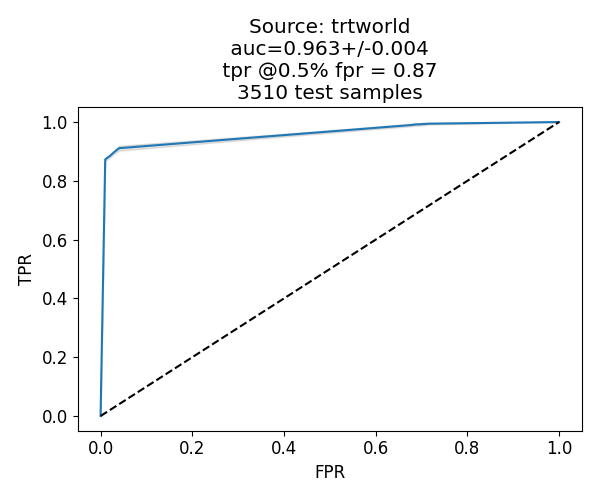

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
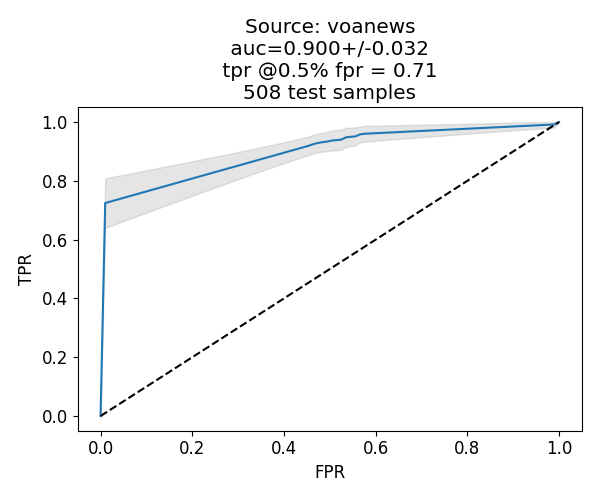

In [25]:
for source in sources:
  plt.figure(figsize=(6,5))

  interp_fpr = np.linspace(0, 1, 100)
  interp_tprs_qm = []
  #interpolate between fpr,tpr datapoints to compute tpr at regular fpr intervals
  for trial in range(NUM_TRIALS):
    fpr = results_per_trial_qm[trial][source]['fpr']
    tpr = results_per_trial_qm[trial][source]['tpr']
    interp_tpr = np.interp(interp_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tprs_qm.append(interp_tpr)

  mean_tpr_qm = np.mean(interp_tprs_qm, axis=0)
  mean_tpr_qm[-1] = 1.0

  std_tpr_qm = np.std(interp_tprs_qm, axis=0)
  tprs_upper_qm = np.minimum(mean_tpr_qm + std_tpr_qm, 1)
  tprs_lower_qm = np.maximum(mean_tpr_qm - std_tpr_qm, 0)
  plt.plot(interp_fpr, mean_tpr_qm,  linestyle="-", label="QF")
  plt.fill_between(interp_fpr, tprs_lower_qm, tprs_upper_qm, color='grey', alpha=.2,
                  label=r'$\pm$ 1 std. dev.')

  auc_mean_qm = float(df_summary.loc[df_summary['source']==source, 'AUC_mean_qm'])
  auc_std_qm = float(df_summary.loc[ df_summary['source']==source, 'AUC_std_qm'])
  tpr_at_fpr_mean_qm = float(df_summary.loc[ df_summary['source']==source, 'tpr_at_fpr_mean_qm'])
  numsamples = int(df_summary.loc[ df_summary['source']==source, 'test_size'])

  plt.plot([0, 1], [0, 1], color="black", linestyle="--")
  plt.title('Source: {}\n auc={:.3f}+/-{:.3f} \n tpr @{:.1f}% fpr = {:.2f} \n{} test samples'.format(
    source, auc_mean_qm, auc_std_qm, 100*FPR_THRESHOLD, tpr_at_fpr_mean_qm, numsamples))
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.tight_layout() 
  plt.show()

## Plot multile curves in each graph, using model that includes quantization matrices as features

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
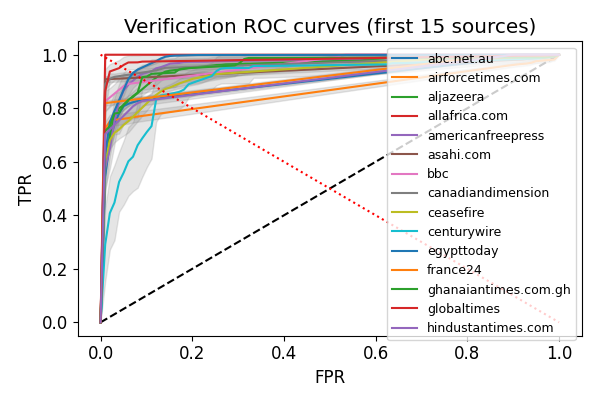

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
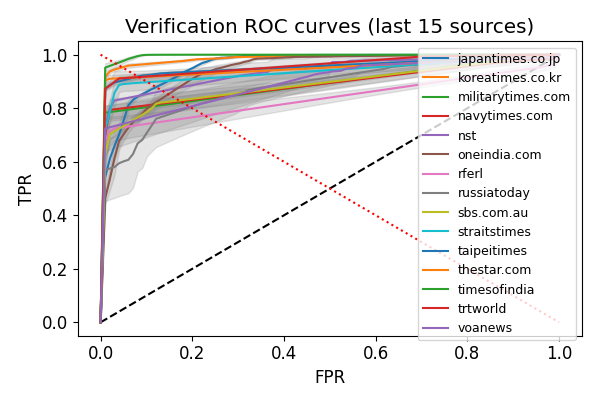

In [26]:
#plot first 15 curves
plt.figure(figsize=(6,4.05))
plt.plot([0, 1], [0, 1], color="black", linestyle="--")
interp_fpr = np.linspace(0, 1, 100)
for source in sources[0:15]:
  interp_tprs = []

  #interpolate between fpr,tpr datapoints to compute tpr at regular fpr intervals
  for trial in range(NUM_TRIALS):
    fpr = results_per_trial_qm[trial][source]['fpr']
    tpr = results_per_trial_qm[trial][source]['tpr']
    interp_tpr = np.interp(interp_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tprs.append(interp_tpr)

  mean_tpr = np.mean(interp_tprs, axis=0)
  mean_tpr[-1] = 1.0

  std_tpr = np.std(interp_tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

  plt.plot(interp_fpr, mean_tpr,  linestyle="-", label=source)

  plt.fill_between(interp_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

  auc_mean = float(df_summary.loc[df_summary['source']==source, 'AUC_mean_qm'])
  auc_std = float(df_summary.loc[ df_summary['source']==source, 'AUC_std_qm'])
  tpr_at_fpr_mean = float(df_summary.loc[ df_summary['source']==source, 'tpr_at_fpr_mean_qm'])
  numsamples = int(df_summary.loc[ df_summary['source']==source, 'test_size'])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(np.linspace(0,1,100), 1-np.linspace(0,1,100), color="red", linestyle="dotted")
plt.legend(fontsize=9)
plt.title("Verification ROC curves (first 15 sources)")
plt.tight_layout()
plt.show()
#uncomment to save:
plt.savefig(os.path.join(RESULTS_FOLDER,"roc_curves_all_curves1.pdf"), bbox_inches='tight')

#Plot second 15 curves:
# plt.figure(figsize=(6,4.85))
plt.figure(figsize=(6,4.05))
plt.plot([0, 1], [0, 1], color="black", linestyle="--")
interp_fpr = np.linspace(0, 1, 100)
for source in sources[15:]:
  interp_tprs = []

  #interpolate between fpr,tpr datapoints to compute tpr at regular fpr intervals
  for trial in range(NUM_TRIALS):
    fpr = results_per_trial_qm[trial][source]['fpr']
    tpr = results_per_trial_qm[trial][source]['tpr']
    interp_tpr = np.interp(interp_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tprs.append(interp_tpr)

  mean_tpr = np.mean(interp_tprs, axis=0)
  mean_tpr[-1] = 1.0

  std_tpr = np.std(interp_tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

  plt.plot(interp_fpr, mean_tpr,  linestyle="-", label=source)

  plt.fill_between(interp_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

  auc_mean = float(df_summary.loc[df_summary['source']==source, 'AUC_mean_qm'])
  auc_std = float(df_summary.loc[ df_summary['source']==source, 'AUC_std_qm'])
  tpr_at_fpr_mean = float(df_summary.loc[ df_summary['source']==source, 'tpr_at_fpr_mean_qm'])
  numsamples = int(df_summary.loc[ df_summary['source']==source, 'test_size'])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(np.linspace(0,1,100), 1-np.linspace(0,1,100), color="red", linestyle="dotted")
plt.legend(fontsize=9)
plt.title("Verification ROC curves (last 15 sources)")
plt.tight_layout()
plt.show()
#uncomment to save:
plt.savefig(os.path.join(RESULTS_FOLDER,"roc_curves_all_curves2.pdf"), bbox_inches='tight')

## Plot single roc curves with uncertainty bands, comparing models that quantization matrices as features vs compression levels only. AND compute mean Equal Error Rates (EERs).

Note on calculation details:
1. We compute the mean equal error rate EER by first computing the mean roc curve, then computing where the mean roc curve hits the antidiagonal. (Mean roc curve is found by fixing and x-axis interpolation grid, then interpolating y values at each x point across the 5 trials, then computing the mean y value at each interpolated x value.)  Why? if someone looked at a roc curve, they would see the mean curve, and they would expect that where that mean curve hits the antidiagonal is the EER.
2. We DO NOT compute the mean EER by taking the mean of 5 EER values from the 5 separate ROC curves. (1 gives similar but slightly different results vs 2.)
3. We compute standard deviation of EER by taking the 5 EER values from the 5 roc curves and computing the std dev spread in them.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
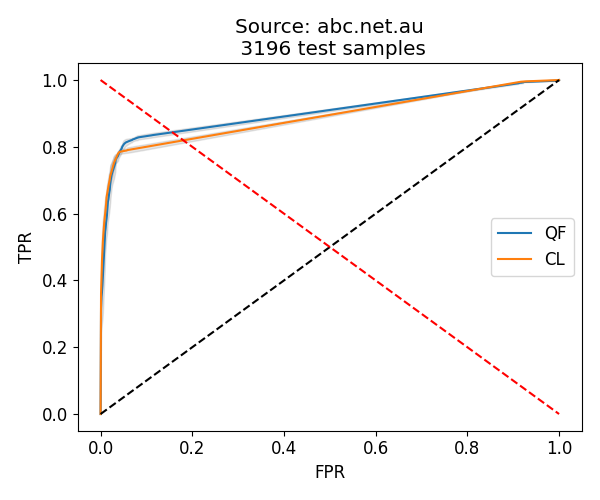

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
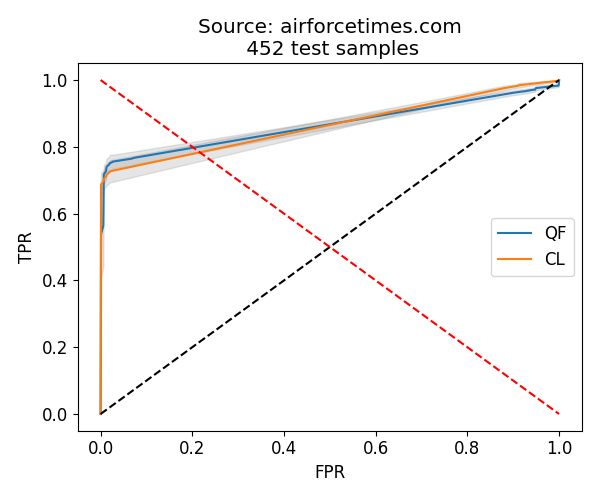

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
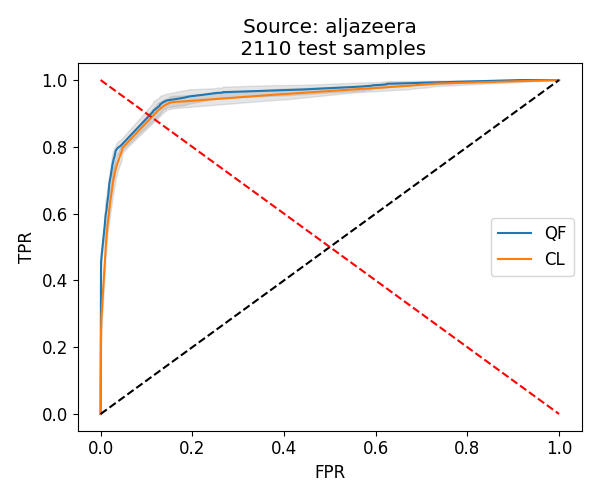

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
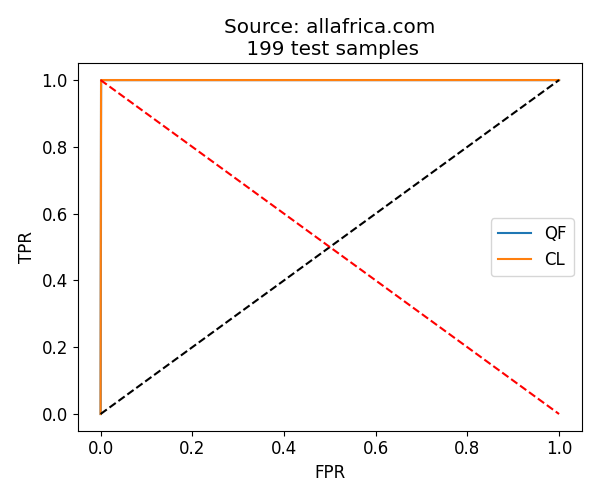

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
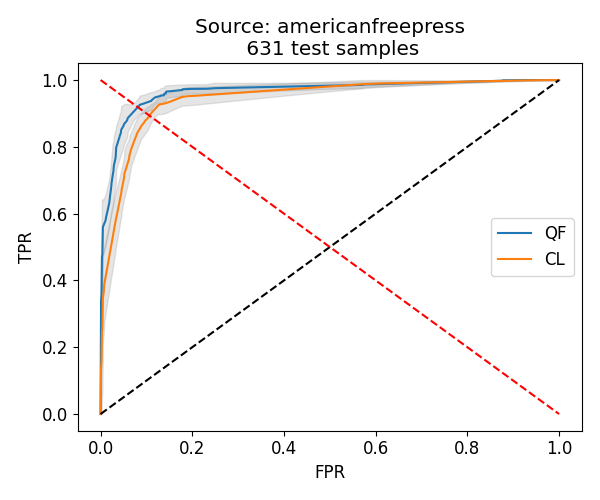

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
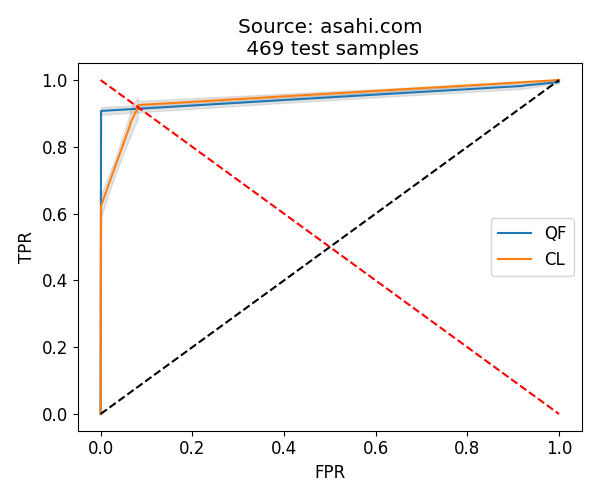

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
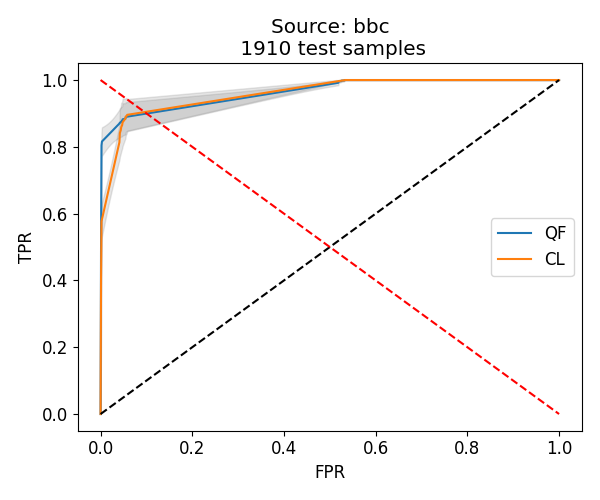

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
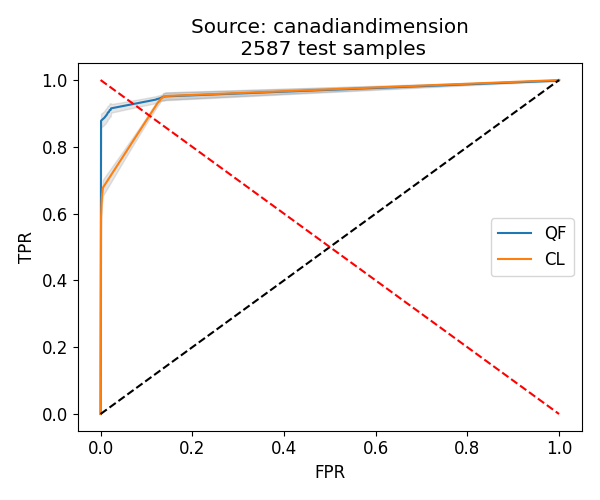

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
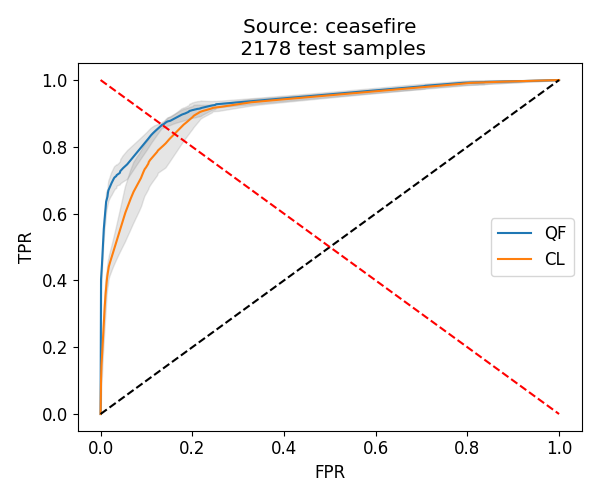

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
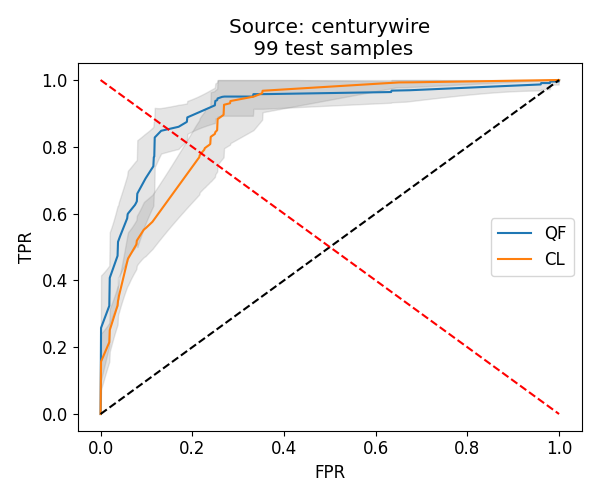

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
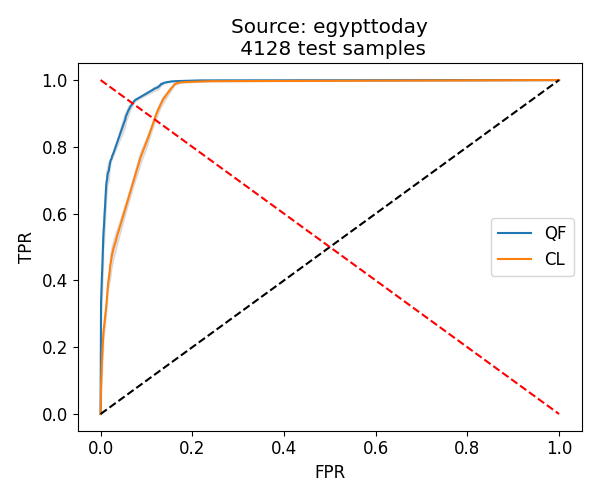

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
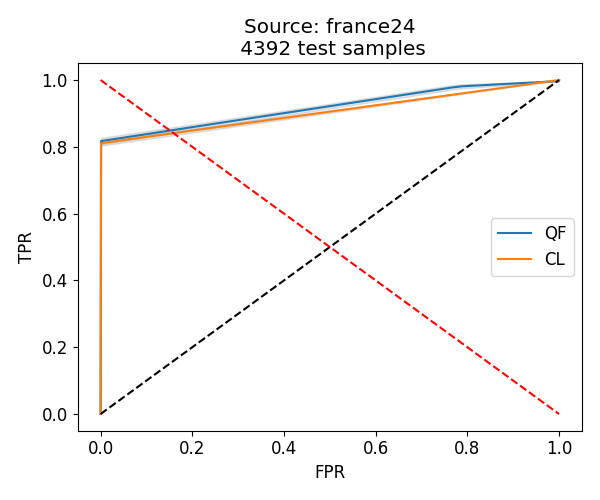

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
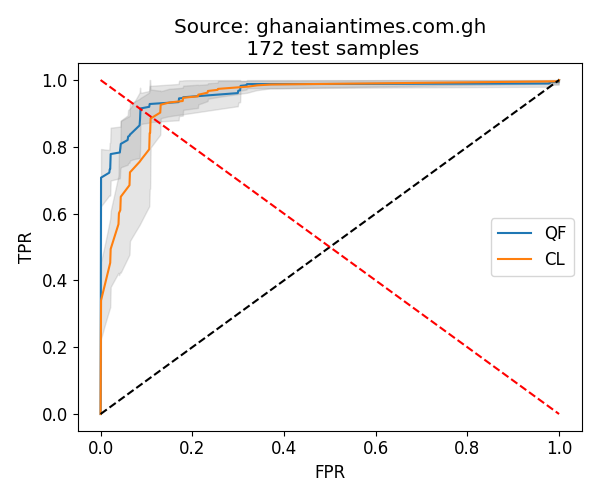

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
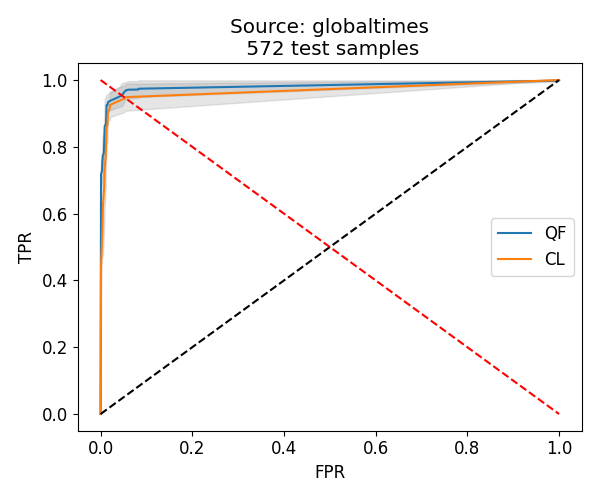

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
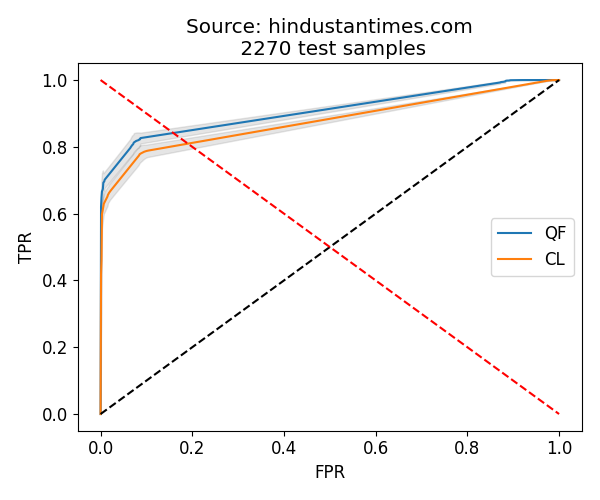

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
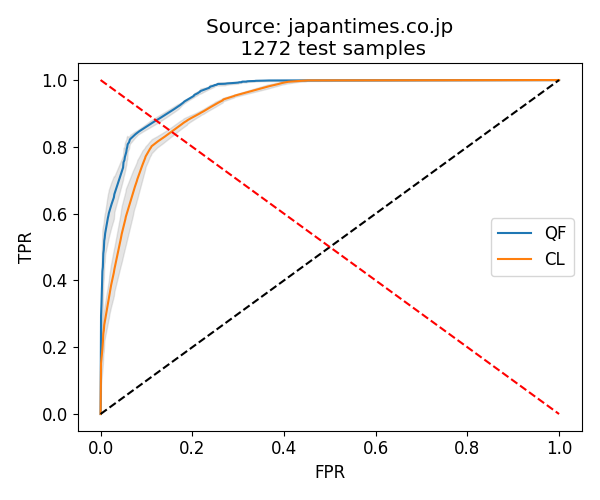

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
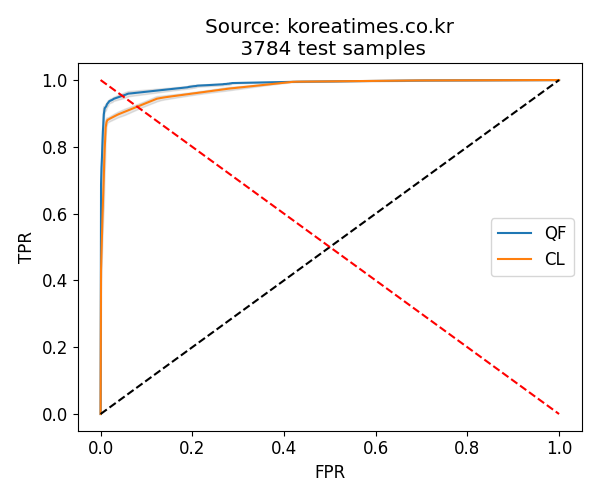

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
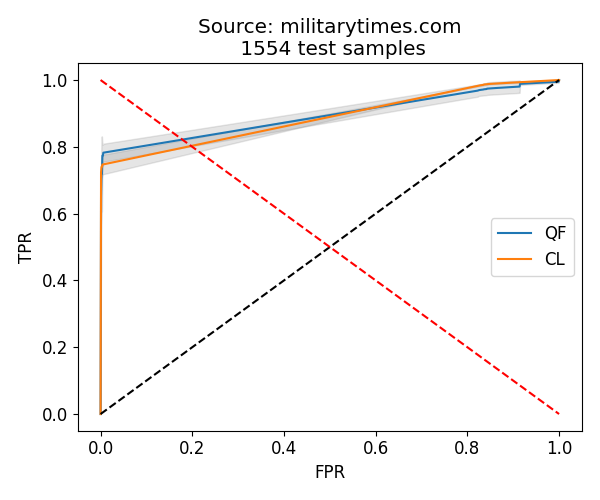

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
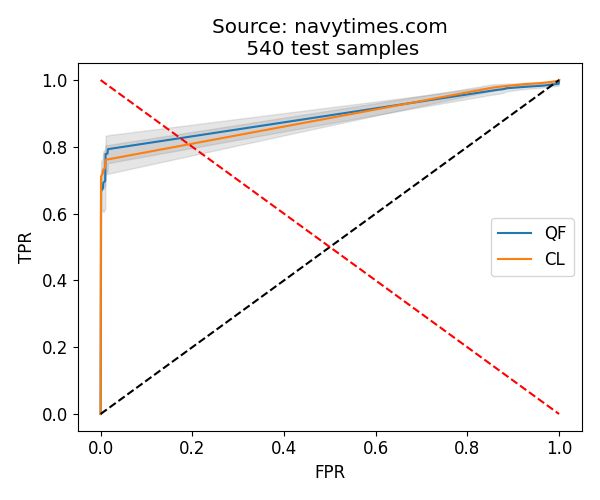

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
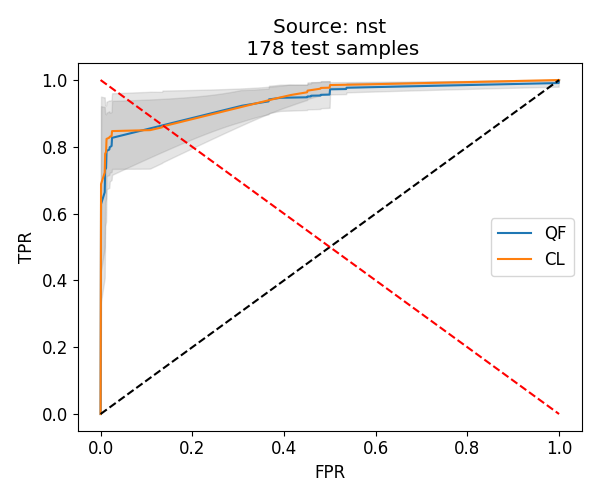

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
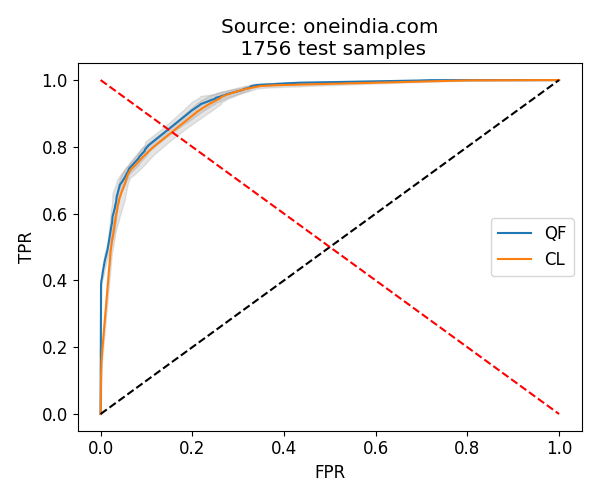

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
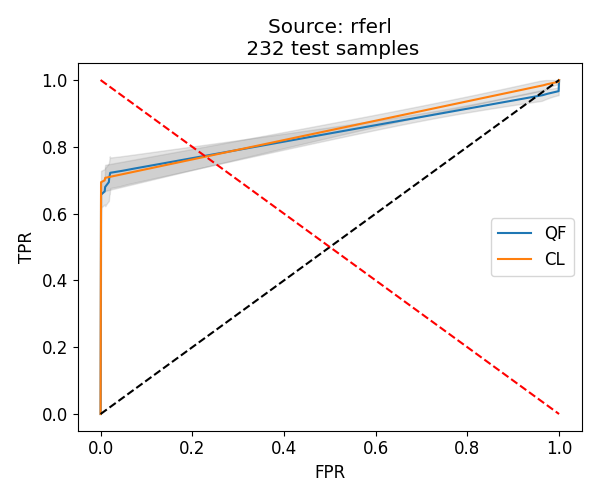

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
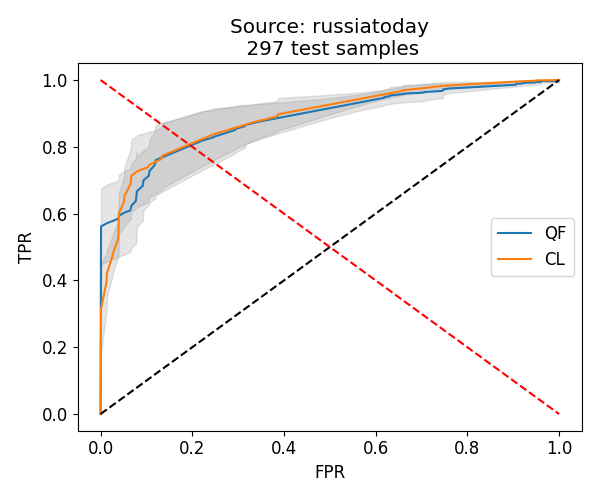

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
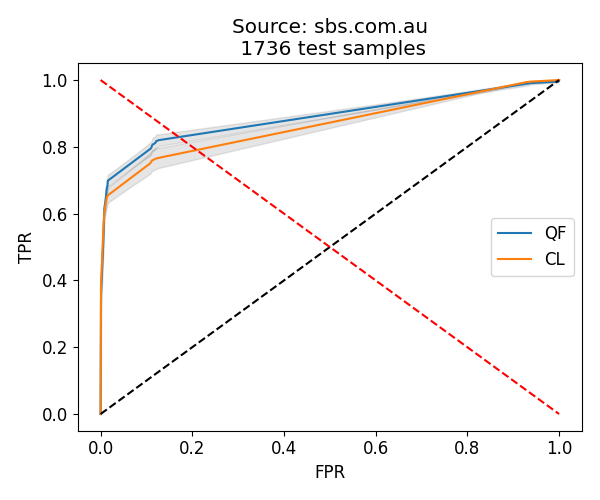

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
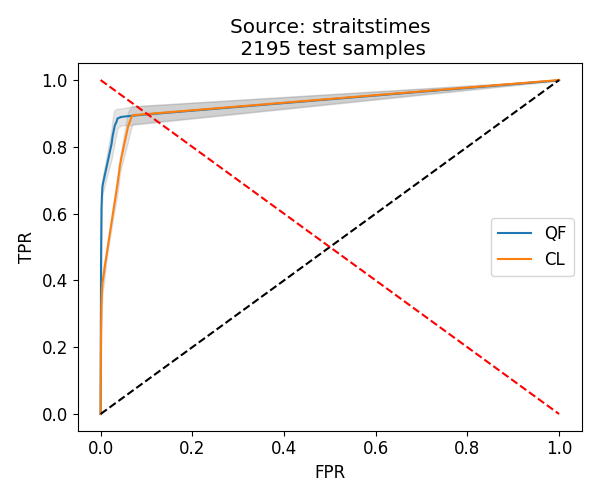

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
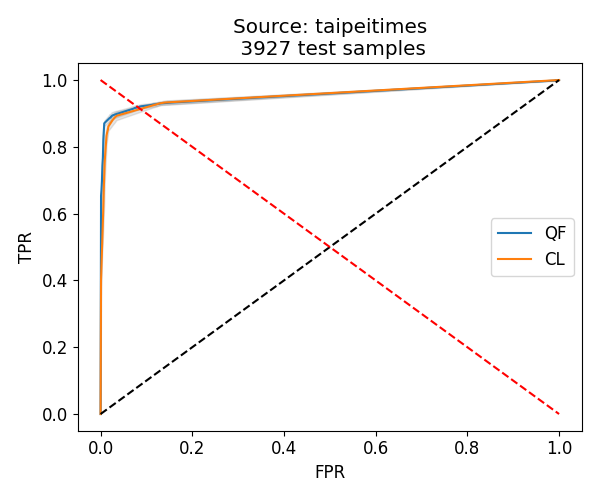

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
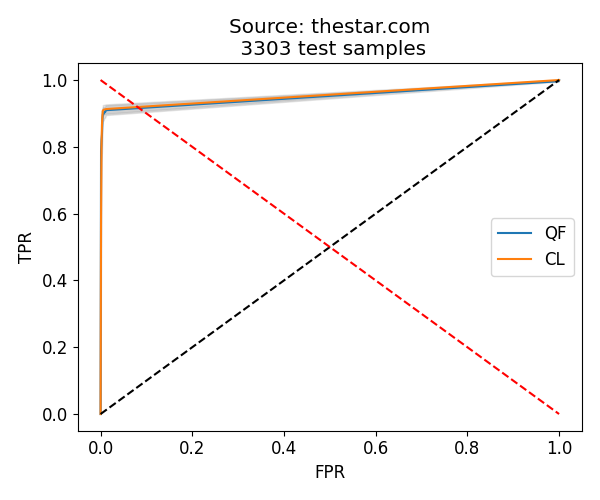

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
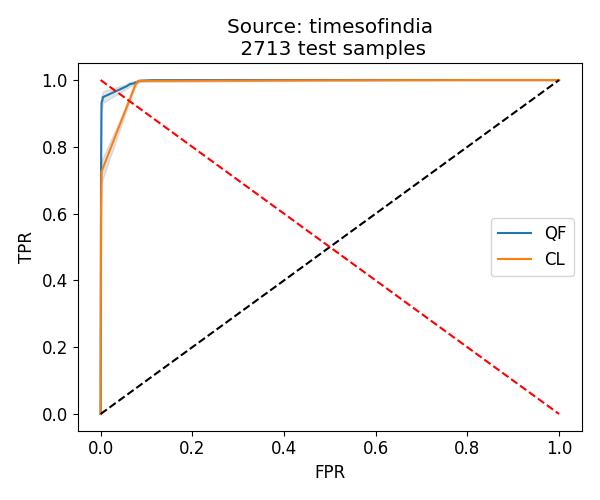

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
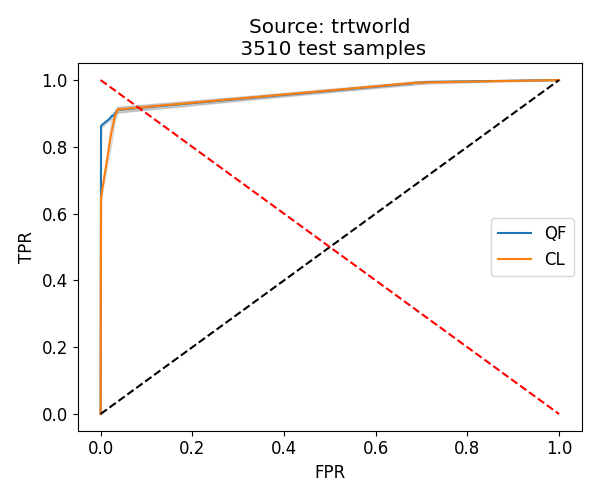

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
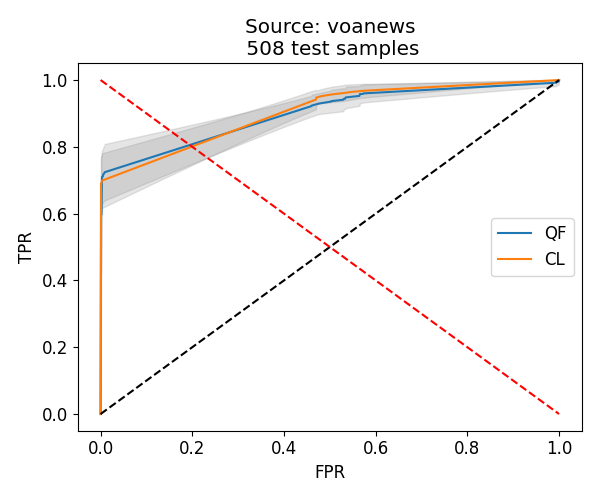

In [27]:
EERs_mean_qm = []
EERs_mean_cl = []

#------------
#New-EER
EERs_all_qm = []
EERs_std_qm = []
EERs_all_cl = []
EERs_std_cl = []
#------------

for source in sources:
  plt.figure(figsize=(6,5))

  interp_fpr = np.linspace(0, 1, 1000)
  
  #-----------------------------------------------
  
  #New-EER
  EERs_per_src_qm = []
  
  interp_tprs_qm = []
  #interpolate between fpr,tpr datapoints to compute tpr at regular fpr intervals
  for trial in range(NUM_TRIALS):
    fpr = results_per_trial_qm[trial][source]['fpr']
    tpr = results_per_trial_qm[trial][source]['tpr']
    interp_tpr = np.interp(interp_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tprs_qm.append(interp_tpr)
  #------------
    #New-EER
    EERs_per_src_qm.append(calculate_eer(interp_fpr, interp_tpr)) #get EERs across all trials for this source
  EERs_std_qm.append( np.std(EERs_per_src_qm) ) #gives a std of EER for each source, across all 5 trials
  EERs_all_qm.append(EERs_per_src_qm) #all data: first index gives src, second index gives trial
  #------------

  mean_tpr_qm = np.mean(interp_tprs_qm, axis=0)
  mean_tpr_qm[-1] = 1.0
  
  EERs_mean_qm.append(calculate_eer(interp_fpr, mean_tpr_qm)) #get 'mean EER' from mean ROC curve
  
  std_tpr_qm = np.std(interp_tprs_qm, axis=0)
  tprs_upper_qm = np.minimum(mean_tpr_qm + std_tpr_qm, 1)
  tprs_lower_qm = np.maximum(mean_tpr_qm - std_tpr_qm, 0)
  plt.plot(interp_fpr, mean_tpr_qm,  linestyle="-", label="QF")
  plt.fill_between(interp_fpr, tprs_lower_qm, tprs_upper_qm, color='grey', alpha=.2)

  auc_mean_qm = float(df_summary.loc[df_summary['source']==source, 'AUC_mean_qm'])
  auc_std_qm = float(df_summary.loc[ df_summary['source']==source, 'AUC_std_qm'])
  tpr_at_fpr_mean_qm = float(df_summary.loc[ df_summary['source']==source, 'tpr_at_fpr_mean_qm'])
  numsamples = int(df_summary.loc[ df_summary['source']==source, 'test_size'])

  #-----------------------------------------------
  
  #New-EER
  EERs_per_src_cl = []
  
  interp_tprs_cl = []
  #interpolate between fpr,tpr datapoints to compute tpr at regular fpr intervals
  for trial in range(NUM_TRIALS):
    fpr = results_per_trial_cl[trial][source]['fpr']
    tpr = results_per_trial_cl[trial][source]['tpr']
    interp_tpr = np.interp(interp_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tprs_cl.append(interp_tpr)
  #------------
    #New-EER
    EERs_per_src_cl.append(calculate_eer(interp_fpr, interp_tpr)) #get EERs across all trials for this source

  EERs_std_cl.append( np.std(EERs_per_src_cl) ) #gives a std of EER for each source, across all 5 trials
  EERs_all_cl.append(EERs_per_src_cl) #all data: first index gives src, second index gives trial
  #------------

  mean_tpr_cl = np.mean(interp_tprs_cl, axis=0)
  mean_tpr_cl[-1] = 1.0
  
  EERs_mean_cl.append(calculate_eer(interp_fpr, mean_tpr_cl))

  std_tpr_cl = np.std(interp_tprs_cl, axis=0)
  tprs_upper_cl = np.minimum(mean_tpr_cl + std_tpr_cl, 1)
  tprs_lower_cl = np.maximum(mean_tpr_cl - std_tpr_cl, 0)
  plt.plot(interp_fpr, mean_tpr_cl,  linestyle="-", label="CL")
  plt.fill_between(interp_fpr, tprs_lower_cl, tprs_upper_cl, color='grey', alpha=.2)

  auc_mean_cl = float(df_summary.loc[df_summary['source']==source, 'AUC_mean_cl'])
  auc_std_cl = float(df_summary.loc[ df_summary['source']==source, 'AUC_std_cl'])
  tpr_at_fpr_mean_cl = float(df_summary.loc[ df_summary['source']==source, 'tpr_at_fpr_mean_cl'])
  #-----------------------------------------------
  
  plt.plot([0, 1], [0, 1], color="black", linestyle="--")
  plt.plot(np.linspace(0,1,100), 1-np.linspace(0,1,100), color="red", linestyle="--")
  plt.title('Source: {}\n {} test samples'.format(
    source, numsamples))
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.legend()
  plt.tight_layout() 
  plt.show()
  
df_summary['EER_mean_cl'] = EERs_mean_cl
df_summary['EER_mean_qm'] = EERs_mean_qm
df_summary['EER_mean_diff'] = df_summary['EER_mean_qm'] - df_summary['EER_mean_cl']

#New-EER
df_summary['EER_std_cl'] = EERs_std_cl
df_summary['EER_std_qm'] = EERs_std_qm

In [28]:
df_summary

source  test_size  AUC_mean_cl  AUC_std_cl  tpr_at_fpr_mean_cl  AUC_mean_qm  AUC_std_qm  tpr_at_fpr_mean_qm  AUC_mean_diff  tpr_at_fpr_mean_diff  EER_mean_cl  EER_mean_qm  EER_mean_diff  EER_std_cl  EER_std_qm
0             abc.net.au       3196     0.890340    0.002833            0.517283     0.901784    0.003605            0.411352       0.011444             -0.105931     0.180597     0.156576      -0.024021    0.005895    0.005313
1      airforcetimes.com        452     0.864762    0.016849            0.694771     0.866129    0.013204            0.559096       0.001368             -0.135675     0.216479     0.202410      -0.014068    0.020390    0.014177
2              aljazeera       2110     0.944326    0.010901            0.358819     0.956332    0.010412            0.511077       0.012006              0.152258     0.111164     0.106413      -0.004751    0.008429    0.010624
3          allafrica.com        199     1.000000    0.000000            1.000000     1.000000    0.000000            1.000000       0.000000              0.000000     0.001000     0.001000       0.000000    0.000000    0.000000
4      americanfreepress        631     0.945467    0.008200            0.345792     0.965780    0.008514            0.559886       0.020314              0.214095     0.106705     0.080996      -0.025709    0.012305    0.014812
5              asahi.com        469     0.947233    0.006847            0.638772     0.948378    0.008006            0.907852       0.001145              0.269081     0.081453     0.085586       0.004134    0.007765    0.009786
6                    bbc       1910     0.960054    0.013814            0.595135     0.963705    0.012271            0.818741       0.003650              0.223606     0.095914     0.100315       0.004402    0.033697    0.030337
7      canadiandimension       2587     0.953285    0.005101            0.676572     0.967643    0.006656            0.882839       0.014358              0.206267     0.106513     0.071819      -0.034693    0.002853    0.008830
8              ceasefire       2178     0.908125    0.015439            0.220775     0.932204    0.008087            0.499606       0.024079              0.278831     0.161203     0.134216      -0.026987    0.021131    0.006010
9            centurywire         99     0.878501    0.040893            0.169902     0.907435    0.029713            0.272527       0.028934              0.102625     0.219453     0.147275      -0.072179    0.042116    0.037855
10            egypttoday       4128     0.949971    0.001610            0.217132     0.980957    0.001043            0.487207       0.030987              0.270075     0.117600     0.069819      -0.047780    0.002357    0.002763
11              france24       4392     0.905254    0.003734            0.811669     0.918677    0.006689            0.818093       0.013424              0.006425     0.159182     0.151209      -0.007973    0.005308    0.007309
12  ghanaiantimes.com.gh        172     0.942966    0.026669            0.362601     0.962048    0.022159            0.710997       0.019082              0.348396     0.112460     0.087024      -0.025435    0.029933    0.022107
13           globaltimes        572     0.968107    0.020745            0.618704     0.981610    0.013116            0.775567       0.013504              0.156863     0.053569     0.044891      -0.008678    0.032347    0.016787
14    hindustantimes.com       2270     0.877038    0.010754            0.613829     0.907767    0.009787            0.674163       0.030729              0.060334     0.190472     0.158613      -0.031860    0.013757    0.012526
15      japantimes.co.jp       1272     0.926657    0.008465            0.214347     0.959599    0.004216            0.440004       0.032942              0.225657     0.154751     0.121152      -0.033599    0.007071    0.005488
16      koreatimes.co.kr       3784     0.976719    0.002383            0.623557     0.987903    0.001531            0.845399       0.011184  

In [29]:
df_summary[['source', 'EER_mean_qm', 'EER_mean_cl']]

source  EER_mean_qm  EER_mean_cl
0             abc.net.au     0.156576     0.180597
1      airforcetimes.com     0.202410     0.216479
2              aljazeera     0.106413     0.111164
3          allafrica.com     0.001000     0.001000
4      americanfreepress     0.080996     0.106705
5              asahi.com     0.085586     0.081453
6                    bbc     0.100315     0.095914
7      canadiandimension     0.071819     0.106513
8              ceasefire     0.134216     0.161203
9            centurywire     0.147275     0.219453
10            egypttoday     0.069819     0.117600
11              france24     0.151209     0.159182
12  ghanaiantimes.com.gh     0.087024     0.112460
13           globaltimes     0.044891     0.053569
14    hindustantimes.com     0.158613     0.190472
15      japantimes.co.jp     0.121152     0.154751
16      koreatimes.co.kr     0.047413     0.079858
17     militarytimes.com     0.178332     0.197396
18         navytimes.com     0.173891     0.192411
19                   nst     0.135501     0.138018
20          oneindia.com     0.147774     0.155667
21                 rferl     0.227203     0.229320
22           russiatoday     0.195995     0.193041
23            sbs.com.au     0.170776     0.209580
24          straitstimes     0.102779     0.101691
25           taipeitimes     0.081602     0.086521
26           thestar.com     0.084020     0.080782
27          timesofindia     0.033441     0.062279
28              trtworld     0.083612     0.082525
29               voanews     0.194553     0.199073

## List formatted strings with values and uncertainties
Print AUCs with mean and uncertainty as string, e.g.
3.14 +/- .02 is formatted as "3.14(2)"

In [30]:
df_summary['AUC_formatted_cl'] = uncertainty_format_arrays(df_summary['AUC_mean_cl'], df_summary['AUC_std_cl'])
df_summary['AUC_formatted_qm'] = uncertainty_format_arrays(df_summary['AUC_mean_qm'], df_summary['AUC_std_qm'])


In [31]:
df_summary

source  test_size  AUC_mean_cl  AUC_std_cl  tpr_at_fpr_mean_cl  AUC_mean_qm  AUC_std_qm  tpr_at_fpr_mean_qm  AUC_mean_diff  tpr_at_fpr_mean_diff  EER_mean_cl  EER_mean_qm  EER_mean_diff  EER_std_cl  EER_std_qm AUC_formatted_cl AUC_formatted_qm
0             abc.net.au       3196     0.890340    0.002833            0.517283     0.901784    0.003605            0.411352       0.011444             -0.105931     0.180597     0.156576      -0.024021    0.005895    0.005313         0.890(3)         0.902(4)
1      airforcetimes.com        452     0.864762    0.016849            0.694771     0.866129    0.013204            0.559096       0.001368             -0.135675     0.216479     0.202410      -0.014068    0.020390    0.014177          0.86(2)          0.87(1)
2              aljazeera       2110     0.944326    0.010901            0.358819     0.956332    0.010412            0.511077       0.012006              0.152258     0.111164     0.106413      -0.004751    0.008429    0.010624          0.94(1)          0.96(1)
3          allafrica.com        199     1.000000    0.000000            1.000000     1.000000    0.000000            1.000000       0.000000              0.000000     0.001000     0.001000       0.000000    0.000000    0.000000           1.0(0)           1.0(0)
4      americanfreepress        631     0.945467    0.008200            0.345792     0.965780    0.008514            0.559886       0.020314              0.214095     0.106705     0.080996      -0.025709    0.012305    0.014812         0.945(8)         0.966(9)
5              asahi.com        469     0.947233    0.006847            0.638772     0.948378    0.008006            0.907852       0.001145              0.269081     0.081453     0.085586       0.004134    0.007765    0.009786         0.947(7)         0.948(8)
6                    bbc       1910     0.960054    0.013814            0.595135     0.963705    0.012271            0.818741       0.003650              0.223606     0.095914     0.100315       0.004402    0.033697    0.030337          0.96(1)          0.96(1)
7      canadiandimension       2587     0.953285    0.005101            0.676572     0.967643    0.006656            0.882839       0.014358              0.206267     0.106513     0.071819      -0.034693    0.002853    0.008830         0.953(5)         0.968(7)
8              ceasefire       2178     0.908125    0.015439            0.220775     0.932204    0.008087            0.499606       0.024079              0.278831     0.161203     0.134216      -0.026987    0.021131    0.006010          0.91(2)         0.932(8)
9            centurywire         99     0.878501    0.040893            0.169902     0.907435    0.029713            0.272527       0.028934              0.102625     0.219453     0.147275      -0.072179    0.042116    0.037855          0.88(4)          0.91(3)
10            egypttoday       4128     0.949971    0.001610            0.217132     0.980957    0.001043            0.487207       0.030987              0.270075     0.117600     0.069819      -0.047780    0.002357    0.002763         0.950(2)         0.981(1)
11              france24       4392     0.905254    0.003734            0.811669     0.918677    0.006689            0.818093       0.013424              0.006425     0.159182     0.151209      -0.007973    0.005308    0.007309         0.905(4)         0.919(7)
12  ghanaiantimes.com.gh        172     0.942966    0.026669            0.362601     0.962048    0.022159            0.710997       0.019082              0.348396     0.112460     0.087024      -0.025435    0.029933    0.022107          0.94(3)          0.96(2)
13           globaltimes        572     0.968107    0.020745            0.618704     0.981610    0.013116            0.775567       0.013504              0.156863     0.053569     0.044891      -0.008678    0.032347    0.016787          0.97(2)          0.98(1)
14    hindustantimes.com       2270     0.877038    0.010754            0.613829     0.9

In [32]:
df_latex = df_summary[['source', 'test_size', 'AUC_formatted_qm', 'AUC_formatted_cl', 'tpr_at_fpr_mean_qm', 'tpr_at_fpr_mean_cl', 'EER_mean_qm','EER_mean_cl']]
df_latex.columns=['source', 'test size', 'AUC (qm)', 'AUC (cl)', 'tpr@fpr (qm)', 'tpr@fpr (cl)', 'EER (qm)','EER (cl)']
df_latex

source  test size   AUC (qm)  AUC (cl)  tpr@fpr (qm)  tpr@fpr (cl)  EER (qm)  EER (cl)
0             abc.net.au       3196   0.902(4)  0.890(3)      0.411352      0.517283  0.156576  0.180597
1      airforcetimes.com        452    0.87(1)   0.86(2)      0.559096      0.694771  0.202410  0.216479
2              aljazeera       2110    0.96(1)   0.94(1)      0.511077      0.358819  0.106413  0.111164
3          allafrica.com        199     1.0(0)    1.0(0)      1.000000      1.000000  0.001000  0.001000
4      americanfreepress        631   0.966(9)  0.945(8)      0.559886      0.345792  0.080996  0.106705
5              asahi.com        469   0.948(8)  0.947(7)      0.907852      0.638772  0.085586  0.081453
6                    bbc       1910    0.96(1)   0.96(1)      0.818741      0.595135  0.100315  0.095914
7      canadiandimension       2587   0.968(7)  0.953(5)      0.882839      0.676572  0.071819  0.106513
8              ceasefire       2178   0.932(8)   0.91(2)      0.499606      0.220775  0.134216  0.161203
9            centurywire         99    0.91(3)   0.88(4)      0.272527      0.169902  0.147275  0.219453
10            egypttoday       4128   0.981(1)  0.950(2)      0.487207      0.217132  0.069819  0.117600
11              france24       4392   0.919(7)  0.905(4)      0.818093      0.811669  0.151209  0.159182
12  ghanaiantimes.com.gh        172    0.96(2)   0.94(3)      0.710997      0.362601  0.087024  0.112460
13           globaltimes        572    0.98(1)   0.97(2)      0.775567      0.618704  0.044891  0.053569
14    hindustantimes.com       2270    0.91(1)   0.88(1)      0.674163      0.613829  0.158613  0.190472
15      japantimes.co.jp       1272   0.960(4)  0.927(8)      0.440004      0.214347  0.121152  0.154751
16      koreatimes.co.kr       3784   0.988(2)  0.977(2)      0.845399      0.623557  0.047413  0.079858
17     militarytimes.com       1554    0.89(2)   0.89(1)      0.773923      0.747147  0.178332  0.197396
18         navytimes.com        540    0.89(2)   0.88(2)      0.676303      0.720833  0.173891  0.192411
19                   nst        178    0.94(3)   0.95(3)      0.646258      0.705736  0.135501  0.138018
20          oneindia.com       1756   0.942(5)  0.933(8)      0.427372      0.212092  0.147774  0.155667
21                 rferl        232    0.84(2)   0.85(2)      0.661759      0.696838  0.227203  0.229320
22           russiatoday        297    0.88(4)   0.89(3)      0.564842      0.341932  0.195995  0.193041
23            sbs.com.au       1736    0.89(1)   0.86(2)      0.483314      0.521946  0.170776  0.209580
24          straitstimes       2195    0.94(2)   0.93(1)      0.688627      0.401448  0.102779  0.101691
25           taipeitimes       3927   0.956(4)  0.954(4)      0.766029      0.577378  0.081602  0.086521
26           thestar.com       3303   0.952(8)  0.955(7)      0.897524      0.909009  0.084020  0.080782
27          timesofindia       2713  0.9972(7)  0.988(2)      0.948615      0.736090  0.033441  0.062279
28              trtworld       3510   0.963(4)  0.960(4)      0.867254      0.683607  0.083612  0.082525
29               voanews        508    0.90(3)   0.90(3)      0.711448      0.699858  0.194553  0.199073

In [33]:

# 3 sig figs use '%.3g'; 3 digits use '%.3f'
latex_table = df_latex.to_latex(index=False, float_format='%.3g')
with open(os.path.join(RESULTS_FOLDER,"table1.tex"),"w") as file1:
  file1.write(latex_table)

In [34]:
print(latex_table)

\begin{tabular}{lrllrrrr}
\toprule
              source &  test size &  AUC (qm) & AUC (cl) &  tpr@fpr (qm) &  tpr@fpr (cl) &  EER (qm) &  EER (cl) \\
\midrule
          abc.net.au &       3196 &  0.902(4) & 0.890(3) &         0.411 &         0.517 &     0.157 &     0.181 \\
   airforcetimes.com &        452 &   0.87(1) &  0.86(2) &         0.559 &         0.695 &     0.202 &     0.216 \\
           aljazeera &       2110 &   0.96(1) &  0.94(1) &         0.511 &         0.359 &     0.106 &     0.111 \\
       allafrica.com &        199 &    1.0(0) &   1.0(0) &             1 &             1 &     0.001 &     0.001 \\
   americanfreepress &        631 &  0.966(9) & 0.945(8) &          0.56 &         0.346 &     0.081 &     0.107 \\
           asahi.com &        469 &  0.948(8) & 0.947(7) &         0.908 &         0.639 &    0.0856 &    0.0815 \\
                 bbc &       1910 &   0.96(1) &  0.96(1) &         0.819 &         0.595 &       0.1 &    0.0959 \\
   canadiandimension &      

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
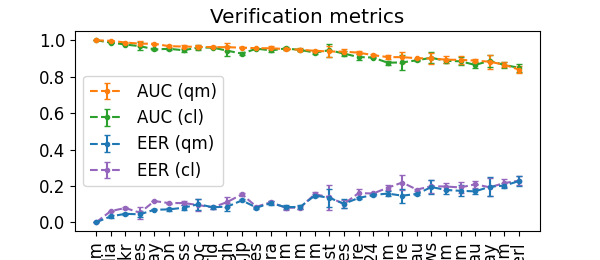

In [35]:
df_metricplot =  df_summary.sort_values(by='AUC_mean_qm', ascending=False).reset_index(drop=True)
sources_metricplot = list(df_metricplot['source'])


# plt.figure(figsize=(6,3.5))
# plt.figure(figsize=(6,2.8))
plt.figure(figsize=(6,2.6))
x_vals = [i for i,_ in enumerate(sources_metricplot)]

#New-EER: add error bars to EER
# plt.plot(x_vals, df_metricplot['EER_mean_cl'], linestyle='--', marker='.', label="EER (cl)", color="tab:purple")
plt.errorbar(x_vals, df_metricplot['EER_mean_cl'], yerr=df_metricplot['EER_std_cl'],
             fmt=".", linestyle="--", label="EER (cl)", color="tab:purple", 
             mfc="tab:purple", mec='tab:purple', ecolor="tab:purple", capsize=2)

#plt.plot(x_vals, df_metricplot['EER_mean_qm'], linestyle='--', marker='.', label="EER (qm)", color="tab:blue")
plt.errorbar(x_vals, df_metricplot['EER_mean_qm'], yerr=df_metricplot['EER_std_qm'],
             fmt=".", linestyle="--", label="EER (qm)", color="tab:blue", 
             mfc="tab:blue", mec='tab:blue', ecolor="tab:blue", capsize=2)

plt.errorbar(x_vals, df_metricplot['AUC_mean_cl'], yerr=df_metricplot['AUC_std_cl'], 
             fmt=".", linestyle="--", label="AUC (cl)", color="tab:green", 
             mfc="tab:green", mec='tab:green', ecolor="tab:green", capsize=2)

plt.errorbar(x_vals, df_metricplot['AUC_mean_qm'], yerr=df_metricplot['AUC_std_qm'], 
             fmt=".", linestyle="--", label="AUC (qm)", color="tab:orange", 
             mfc="tab:orange", mec='tab:orange', ecolor="tab:orange", capsize=2)


plt.xticks(x_vals, sources_metricplot, rotation=90)

handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[3], handles[2], handles[1], handles[0]]
labels = [labels[3], labels[2], labels[1], labels[0]]
plt.legend(handles, labels, loc="center left")

plt.title("Verification metrics")
plt.yticks(np.arange(0.0, 1.2, 0.2))
# plt.tight_layout()
plt.show()
# #uncomment to save:
plt.savefig(os.path.join(RESULTS_FOLDER,"verification_metrics_plot.pdf"), bbox_inches='tight')

In [36]:
df_metricplot

source  test_size  AUC_mean_cl  AUC_std_cl  tpr_at_fpr_mean_cl  AUC_mean_qm  AUC_std_qm  tpr_at_fpr_mean_qm  AUC_mean_diff  tpr_at_fpr_mean_diff  EER_mean_cl  EER_mean_qm  EER_mean_diff  EER_std_cl  EER_std_qm AUC_formatted_cl AUC_formatted_qm
0          allafrica.com        199     1.000000    0.000000            1.000000     1.000000    0.000000            1.000000       0.000000              0.000000     0.001000     0.001000       0.000000    0.000000    0.000000           1.0(0)           1.0(0)
1           timesofindia       2713     0.987723    0.002379            0.736090     0.997150    0.000683            0.948615       0.009428              0.212525     0.062279     0.033441      -0.028838    0.001367    0.006346         0.988(2)        0.9972(7)
2       koreatimes.co.kr       3784     0.976719    0.002383            0.623557     0.987903    0.001531            0.845399       0.011184              0.221841     0.079858     0.047413      -0.032445    0.005300    0.005487         0.977(2)         0.988(2)
3            globaltimes        572     0.968107    0.020745            0.618704     0.981610    0.013116            0.775567       0.013504              0.156863     0.053569     0.044891      -0.008678    0.032347    0.016787          0.97(2)          0.98(1)
4             egypttoday       4128     0.949971    0.001610            0.217132     0.980957    0.001043            0.487207       0.030987              0.270075     0.117600     0.069819      -0.047780    0.002357    0.002763         0.950(2)         0.981(1)
5      canadiandimension       2587     0.953285    0.005101            0.676572     0.967643    0.006656            0.882839       0.014358              0.206267     0.106513     0.071819      -0.034693    0.002853    0.008830         0.953(5)         0.968(7)
6      americanfreepress        631     0.945467    0.008200            0.345792     0.965780    0.008514            0.559886       0.020314              0.214095     0.106705     0.080996      -0.025709    0.012305    0.014812         0.945(8)         0.966(9)
7                    bbc       1910     0.960054    0.013814            0.595135     0.963705    0.012271            0.818741       0.003650              0.223606     0.095914     0.100315       0.004402    0.033697    0.030337          0.96(1)          0.96(1)
8               trtworld       3510     0.959949    0.004313            0.683607     0.962694    0.003884            0.867254       0.002745              0.183647     0.082525     0.083612       0.001087    0.007121    0.007133         0.960(4)         0.963(4)
9   ghanaiantimes.com.gh        172     0.942966    0.026669            0.362601     0.962048    0.022159            0.710997       0.019082              0.348396     0.112460     0.087024      -0.025435    0.029933    0.022107          0.94(3)          0.96(2)
10      japantimes.co.jp       1272     0.926657    0.008465            0.214347     0.959599    0.004216            0.440004       0.032942              0.225657     0.154751     0.121152      -0.033599    0.007071    0.005488         0.927(8)         0.960(4)
11           taipeitimes       3927     0.954355    0.004105            0.577378     0.956405    0.003701            0.766029       0.002049              0.188651     0.086521     0.081602      -0.004920    0.006082    0.004928         0.954(4)         0.956(4)
12             aljazeera       2110     0.944326    0.010901            0.358819     0.956332    0.010412            0.511077       0.012006              0.152258     0.111164     0.106413      -0.004751    0.008429    0.010624          0.94(1)          0.96(1)
13           thestar.com       3303     0.955251    0.007014            0.909009     0.952012    0.007733            0.897524      -0.003239             -0.011484     0.080782     0.084020       0.003238    0.011884    0.012381         0.955(7)         0.952(8)
14             asahi.com        469     0.947233    0.006847            0.638772     0.9

## Extra summary stats:
Compute some extra summary stats:  
-average AUC and EER across 30 sources  
-min AUC  
-max EER  

In [37]:
# df_summary

print("mean AUC across all sources was {:.2f}".format(df_summary['AUC_mean_qm'].mean()))
with open(os.path.join(RESULTS_FOLDER,"AUC_avg_across_sources.txt"),"w") as file1:
  file1.write("{:.2f}".format(df_summary['AUC_mean_qm'].mean()))

print("mean EER across all sources was {:.2f}".format(df_summary['EER_mean_qm'].mean()))
with open(os.path.join(RESULTS_FOLDER,"EER_avg_across_sources.txt"),"w") as file1:
  file1.write("{:.2f}".format(df_summary['EER_mean_qm'].mean()))

print("min AUC across all sources was {:.2f}".format(df_summary['AUC_mean_qm'].min()))
with open(os.path.join(RESULTS_FOLDER,"AUC_min_across_sources.txt"),"w") as file1:
  file1.write("{:.2f}".format(df_summary['AUC_mean_qm'].min()))

print("max EER across all sources was {:.2f}".format(df_summary['EER_mean_qm'].max()))
with open(os.path.join(RESULTS_FOLDER,"EER_max_across_sources.txt"),"w") as file1:
  file1.write("{:.2f}".format(df_summary['EER_mean_qm'].max()))



mean AUC across all sources was 0.94
mean EER across all sources was 0.12
min AUC across all sources was 0.84
max EER across all sources was 0.23


## Optional extra plot:
Test combining the metric plots from experiments 1 and 2, to save space in the paper.
* First load the data from Exp 02
* Then plot it along with the data from Exp 01.

**CAUTION**: Remember that the time generalization results (from experiment 02) are computed on different splits of the dataset. Keep that in mind when comparing it to the results from this experiment 01 -- the testing data composition differs between exp 01 and 02. 

In [39]:
df_metricplot_exp2 = pd.read_csv("results/exp_02/exp_02_metrics_plot_data.csv")

old_col_names = list(df_metricplot_exp2.columns)
new_col_names = []
for cn in old_col_names:
  if cn != "source":
    cn += "_time"
  new_col_names.append(cn)
df_metricplot_exp2.columns = new_col_names

df_exp01_02_joined = pd.merge(
    df_metricplot,
    df_metricplot_exp2,
    how="inner",
    on='source')

df_exp01_02_joined = df_exp01_02_joined.sort_values(by='AUC_mean_qm', ascending=False).reset_index(drop=True)

In [40]:
df_exp01_02_joined

source  test_size  AUC_mean_cl  AUC_std_cl  tpr_at_fpr_mean_cl  AUC_mean_qm  AUC_std_qm  tpr_at_fpr_mean_qm  AUC_mean_diff  tpr_at_fpr_mean_diff  EER_mean_cl  EER_mean_qm  EER_mean_diff  EER_std_cl  EER_std_qm AUC_formatted_cl AUC_formatted_qm  test_size_time  AUC_mean_qm_time  AUC_std_qm_time  tpr_at_fpr_mean_qm_time AUC_formatted_qm_time  EER_mean_qm_time  EER_std_qm_time
0          allafrica.com        199     1.000000    0.000000            1.000000     1.000000    0.000000            1.000000       0.000000              0.000000     0.001000     0.001000       0.000000    0.000000    0.000000           1.0(0)           1.0(0)             194          1.000000         0.000000                 1.000000                1.0(0)          0.001000         0.000000
1           timesofindia       2713     0.987723    0.002379            0.736090     0.997150    0.000683            0.948615       0.009428              0.212525     0.062279     0.033441      -0.028838    0.001367    0.006346         0.988(2)        0.9972(7)            2126          0.997075         0.000391                 0.938238             0.9971(4)          0.035633         0.002798
2       koreatimes.co.kr       3784     0.976719    0.002383            0.623557     0.987903    0.001531            0.845399       0.011184              0.221841     0.079858     0.047413      -0.032445    0.005300    0.005487         0.977(2)         0.988(2)            4114          0.986324         0.001543                 0.918583              0.986(2)          0.051826         0.007156
3            globaltimes        572     0.968107    0.020745            0.618704     0.981610    0.013116            0.775567       0.013504              0.156863     0.053569     0.044891      -0.008678    0.032347    0.016787          0.97(2)          0.98(1)             712          0.993448         0.003367                 0.806280              0.993(3)          0.032175         0.007696
4             egypttoday       4128     0.949971    0.001610            0.217132     0.980957    0.001043            0.487207       0.030987              0.270075     0.117600     0.069819      -0.047780    0.002357    0.002763         0.950(2)         0.981(1)            4393          0.962130         0.000292                 0.324451             0.9621(3)          0.111326         0.002119
5      canadiandimension       2587     0.953285    0.005101            0.676572     0.967643    0.006656            0.882839       0.014358              0.206267     0.106513     0.071819      -0.034693    0.002853    0.008830         0.953(5)         0.968(7)            2996          0.975462         0.003536                 0.907846              0.975(4)          0.063367         0.003645
6      americanfreepress        631     0.945467    0.008200            0.345792     0.965780    0.008514            0.559886       0.020314              0.214095     0.106705     0.080996      -0.025709    0.012305    0.014812         0.945(8)         0.966(9)             593          0.927321         0.028026                 0.227682               0.93(3)          0.094418         0.011453
7                    bbc       1910     0.960054    0.013814            0.595135     0.963705    0.012271            0.818741       0.003650              0.223606     0.095914     0.100315       0.004402    0.033697    0.030337          0.96(1)          0.96(1)            2460          0.929389         0.019308                 0.579642               0.93(2)          0.151775         0.043489
8               trtworld       3510     0.959949    0.004313            0.683607     0.962694    0.003884            0.867254       0.002745              0.183647     0.082525     0.083612       0.001087    0.007121    0.007133         0.960(4)         0.963(4)            3459          0.962438         0.004224                 0.869442              0.962(4)          0.075850         0.005751
9   ghanaiantimes.com.gh        172     0.942966    0.026669        

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
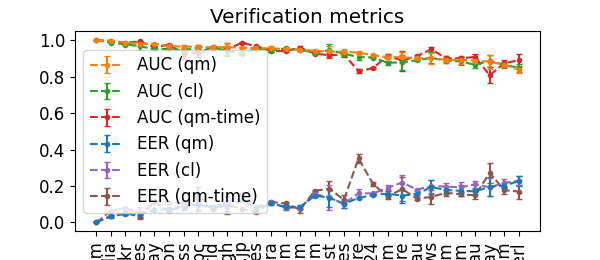

In [41]:
df_metricplot =  df_summary.sort_values(by='AUC_mean_qm', ascending=False).reset_index(drop=True)
sources_metricplot = list(df_metricplot['source'])


# plt.figure(figsize=(6,3.5))
# plt.figure(figsize=(6,2.8))
plt.figure(figsize=(6,2.6))
x_vals = [i for i,_ in enumerate(sources_metricplot)]

plt.errorbar(x_vals, df_exp01_02_joined['EER_mean_qm_time'], yerr=df_exp01_02_joined['EER_std_qm_time'],
             fmt=".", linestyle="--", label="EER (qm-time)", color="tab:brown", 
             mfc="tab:brown", mec='tab:brown', ecolor="tab:brown", capsize=2)

#New-EER: add error bars to EER
# plt.plot(x_vals, df_metricplot['EER_mean_cl'], linestyle='--', marker='.', label="EER (cl)", color="tab:purple")
plt.errorbar(x_vals, df_metricplot['EER_mean_cl'], yerr=df_metricplot['EER_std_cl'],
             fmt=".", linestyle="--", label="EER (cl)", color="tab:purple", 
             mfc="tab:purple", mec='tab:purple', ecolor="tab:purple", capsize=2)

#plt.plot(x_vals, df_metricplot['EER_mean_qm'], linestyle='--', marker='.', label="EER (qm)", color="tab:blue")
plt.errorbar(x_vals, df_metricplot['EER_mean_qm'], yerr=df_metricplot['EER_std_qm'],
             fmt=".", linestyle="--", label="EER (qm)", color="tab:blue", 
             mfc="tab:blue", mec='tab:blue', ecolor="tab:blue", capsize=2)



#--------------

plt.errorbar(x_vals, df_exp01_02_joined['AUC_mean_qm_time'], yerr=df_exp01_02_joined['AUC_std_qm_time'], 
             fmt=".", linestyle="--", label="AUC (qm-time)", color="tab:red", 
             mfc="tab:red", mec='tab:red', ecolor="tab:red", capsize=2)

plt.errorbar(x_vals, df_metricplot['AUC_mean_cl'], yerr=df_metricplot['AUC_std_cl'], 
             fmt=".", linestyle="--", label="AUC (cl)", color="tab:green", 
             mfc="tab:green", mec='tab:green', ecolor="tab:green", capsize=2)

plt.errorbar(x_vals, df_metricplot['AUC_mean_qm'], yerr=df_metricplot['AUC_std_qm'], 
             fmt=".", linestyle="--", label="AUC (qm)", color="tab:orange", 
             mfc="tab:orange", mec='tab:orange', ecolor="tab:orange", capsize=2)




plt.xticks(x_vals, sources_metricplot, rotation=90)

handles, labels = plt.gca().get_legend_handles_labels()
handles.reverse()
labels.reverse()
plt.legend(handles, labels, loc="center left")

plt.title("Verification metrics")
plt.yticks(np.arange(0.0, 1.2, 0.2))
# plt.tight_layout()
plt.show()
# #uncomment to save:
plt.savefig(os.path.join(RESULTS_FOLDER,"verification_metrics_plot_v2_combine_exp1_and_2.pdf"), bbox_inches='tight')